# FEIII Challenge with SVM
## Task
Add a column *score* (ranking score, 0<score<1), such that:

  >We interpret confidence broadly as follows: the sentences in the triple are relevant
  >and interesting with respect to the filing financial entity, and/or the sentences provide evidence
  >for the specific relationship, described by the role keyword, between the filing financial entity
  >and the mentioned financial entity.
 
Ranking per group, whereas groups are the 10 roles.

https://ir.nist.gov/feiii/2017-challenge.html


Example 10-k filing:
https://www.sec.gov/ix?doc=/Archives/edgar/data/1432271/000137647417000016/rmp-20161231.htm

## Expert Ratings

**Highly Relevant Sentences:** One type of highly relevant sentences will identify potential
sources of significant (large) expenses and/or significant business opportunities. Examples of
the source of the expenses or opportunities include litigation, spin-offs, acquisitions, etc. Most of
these sentences describe a change from the status quo or current situation. Another type of
highly relevant sentence will identify corporate character, e.g., the compensation of senior
executives or commentary about business activities.

**Relevant Sentences:** One type of relevant sentences will identify existing assets, liabilities,
revenues, or expenses. They may be very specific, e.g., interest rate expenses. Another type of
relevant sentences will also identify the size and nature of current business activities, e.g., retail
division, underwriting, investment banking, etc.

**Neutral Sentences:** These sentences may describe the type of business activity, the location of
some business entity or activity. They are informative sentences but convey less information
value compared to the highly relevant or relevant sentences.

**Irrelevant:** This is boilerplate text that is not informative. In some cases, the extracted
sentences may be irrelevant to the filing financial entity or the mentioned entity or the role.

## init stuff

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import os
from collections import Counter
import spacy
import re
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.model_selection import train_test_split
nlp = spacy.load('en')

In [2]:
# forward mapping
#rating_map = {'Irrelevant':0.0, 'Neutral': 0.4, 'Relevant':0.75, 'Highly relevant': 1.0}
rating_map  = {'Irrelevant': 0, 'Neutral': 0, 'Relevant': 1, 'Highly relevant': 2}
rating_map2 = {'irrelevant': 0, 'neutral': 0, 'relevant': 1, 'highly': 2}

# normally (wikipedia) scale 0,1,2,3 
rating_map  = {'Irrelevant': 0, 'Neutral': 1, 'Relevant': 2, 'Highly relevant': 3}
rating_map2 = {'irrelevant': 0, 'neutral': 1, 'relevant': 2, 'highly': 3}

# text says "The pRL gets one point of gain for each relevant triple and two points for each highly relevant triple"

# backward mapping
def avg2rating(rating_avg):
    try:
        if rating_avg < 1.0:
            return 'irrelevant'
        if rating_avg <= 1.7:
            return 'neutral'
        if rating_avg <= 2.5:
            return 'relevant'
        return 'highly'
    except:
        return rating_avg

def dcg_np(ol, p):
    ol = ol[:p]
    try:
        return ol[0] + np.sum(ol[1:] / np.log2(np.arange(2, ol.size+1)))
    except:
        return np.nan

def ndcg_np(ol, ideal, p):
    try:
        return dcg_np(ol, p) / dcg_np(ideal, p)
    except:
        return np.nan
    
def ndcg(frame, p=None):
    if not p:
        p = len(frame)
    
    scored = np.array(frame.sort_values('score', ascending=False)['rating_avg'])
    ideal = np.array(frame.sort_values('rating_avg', ascending=False)['rating_avg'])
    
    return ndcg_np(scored, ideal, p)

def ndcg2(frame, scoring, p=None):
    if not p:
        p = len(frame)
    
    frmap = frame['rating'].map(rating_map2)
    s = np.array([sc[1] for sc in scoring])
    
    scored = np.array([frmap.loc[scoring[i][0]] for i in (-s).argsort()])
    ideal = np.array(frmap.sort_values(ascending=False))
    
    return ndcg_np(scored, ideal, p)

In [3]:
from IPython.display import HTML
import pprint

def pp(obj):
    return pprint.pformat(obj).replace('\n','<br />')

frame = pd.DataFrame()
list_ = []

wsetdir = '/home/tim/Uni/HPI/workspace/FEII/'
wset = pd.read_csv(wsetdir+'Working.csv')

traindir = '/home/tim/Uni/HPI/workspace/FEII/Training/'
for file in os.listdir(traindir):
    if file.endswith('.csv'):
        df = pd.read_csv(traindir+file,index_col=None)
        df['FILE'] = [file] * len(df)
        print('reading file', file,'with',len(df),'entries.')
        list_.append(df)

train = pd.concat(list_)
train.reset_index(drop=True, inplace=True)

train['grp'] = train['ROLE'].map(lambda x: re.sub("(ies|y|s)$","",x)).str.lower()
wset['grp'] = wset['ROLE'].map(lambda x: re.sub("(ies|y|s)$","",x)).str.lower()

roles = dict(Counter(wset['grp']))

out = '<table><tr><th></th><th>WORKING SET</th><th>TRAINING SET</th></tr>'
out+= '<tr><td>#ROWS</td><td>'+str(len(wset))+'</td><td>'+str(len(train))+'</td></tr>'
out+= '<tr><td>COLUMNS</td><td>'+pp(wset.columns)+'</td><td>'+pp(train.columns)+'</td></tr>'
out+= '<tr><td>ROLES</td><td>'+pp(dict(Counter(wset['grp'])))+'</td><td>'+pp(dict(Counter(train['grp'])))+'</td></tr>'
out+= '<tr><td>COMPANIES</td><td>'+pp(dict(Counter(wset['FILER_NAME'])))+'</td><td>'+pp(dict(Counter(train['FILER_NAME'])))+'</td></tr>'
out+= '<tr><td>Expert ratings</td><td>none</td><td>'
for c in train.filter(regex=("RATING")):
    out+= str(c)+' '+str(Counter(train[c]))+'<br/>'
out+= '</td></tr>'
out+= '</table>'

    
HTML(out)

reading file STATE-STREET_2016.csv with 23 entries.
reading file STATE-STREET_2014.csv with 26 entries.
reading file PNC_2016.csv with 33 entries.
reading file PNC_2014.csv with 38 entries.
reading file JPM_2016.csv with 52 entries.
reading file COMERICA_2016.csv with 11 entries.
reading file FIFTH-THIRD_2014.csv with 36 entries.
reading file CITIGROUP_2014.csv with 52 entries.
reading file AMERICAN-EXPRESS_2015.csv with 11 entries.
reading file BANK-OF-AMERICA_2015.csv with 74 entries.
reading file ALLY_2016.csv with 44 entries.
reading file CITIGROUP_2016.csv with 50 entries.
reading file ALLY_2014.csv with 40 entries.
reading file SUNTRUST_2013.csv with 35 entries.
reading file DISCOVER_2014.csv with 41 entries.
reading file MORGAN-STANLEY_2015.csv with 128 entries.
reading file SUNTRUST_2016.csv with 27 entries.
reading file BBT_2014.csv with 14 entries.
reading file GENERAL-ELECTRIC_2013.csv with 21 entries.
reading file FIFTH-THIRD_2015.csv with 46 entries.
reading file CAPITAL-O

,WORKING SET,TRAINING SET
#ROWS,9597,975
COLUMNS,"Index(['DOCUMENT_TYPE', 'FILER_NAME', 'FILER_CIK', 'FILING_INTERVAL', 'FILING_DATE', 'MENTIONED_FINANCIAL_ENTITY', 'PP_RSSD_ID', 'ROLE', 'THREE_SENTENCES', 'grp'], dtype='object')","Index(['COMMENT_EXPERT_1', 'COMMENT_EXPERT_1.1', 'COMMENT_EXPERT_10', 'COMMENT_EXPERT_2', 'COMMENT_EXPERT_3', 'COMMENT_EXPERT_4', 'COMMENT_EXPERT_5', 'COMMENT_EXPERT_6', 'COMMENT_EXPERT_7', 'COMMENT_EXPERT_9', 'DOCUMENT_TYPE', 'FILE', 'FILER_CIK', 'FILER_NAME', 'FILING_DATE', 'FILING_INTERVAL', 'MENTIONED_FINANCIAL_ENTITY', 'PP_RSSD_ID', 'RATING_EXPERT_1', 'RATING_EXPERT_1.1', 'RATING_EXPERT_10', 'RATING_EXPERT_2', 'RATING_EXPERT_3', 'RATING_EXPERT_4', 'RATING_EXPERT_5', 'RATING_EXPERT_6', 'RATING_EXPERT_7', 'RATING_EXPERT_9', 'ROLE', 'THREE_SENTENCES', 'grp'], dtype='object')"
ROLES,"{'affiliate': 1306, 'agent': 558, 'counterpart': 1168, 'guarantor': 359, 'insurer': 487, 'issuer': 1214, 'seller': 537, 'servicer': 632, 'trustee': 2763, 'underwriter': 573}","{'affiliate': 186, 'agent': 61, 'counterpart': 64, 'guarantor': 34, 'insurer': 19, 'issuer': 129, 'seller': 20, 'servicer': 21, 'trustee': 420, 'underwriter': 21}"
COMPANIES,"{'AMERICAN EXPRESS CO': 114, 'Ally Financial Inc': 554, 'BANK OF AMERICA CORP': 924, 'BB&T CORP': 100, 'Bank of New York Mellon Corp': 365, 'CAPITAL ONE FINANCIAL CORP': 305, 'CITIGROUP INC': 442, 'COMERICA INC': 59, 'Discover Financial Services': 325, 'FEDERAL_HOME_LOAN_MORTGAGE_CORP': 1199, 'FEDERAL_NATIONAL_MORTGAGE_ASSOCIATION_FANNIE_MAE': 615, 'FIFTH THIRD BANCORP': 299, 'GENERAL ELECTRIC CO': 153, 'GOLDMAN SACHS GROUP INC': 434, 'HUNTINGTON BANCSHARES INC': 27, 'JPMORGAN CHASE & CO': 945, 'KEYCORP': 76, 'M&T BANK CORP': 220, 'MORGAN STANLEY': 815, 'NORTHERN TRUST CORP': 246, 'PNC FINANCIAL SERVICES GROUP INC': 289, 'SCHWAB_CHARLES_CORP ': 107, 'STATE STREET CORP': 326, 'SUNTRUST BANKS INC': 349, 'US_BANCORP': 96, 'WELLS FARGO & COMPANY': 151, 'ZIONS BANCORPORATION': 62}","{'AMERICAN EXPRESS CO': 11, 'Ally Financial Inc': 84, 'BANK OF AMERICA CORP': 162, 'BB&T CORP': 14, 'CAPITAL ONE FINANCIAL CORP': 25, 'CITIGROUP INC': 102, 'COMERICA INC': 11, 'Discover Financial Services': 41, 'FIFTH THIRD BANCORP': 82, 'GENERAL ELECTRIC CO': 21, 'JPMORGAN CHASE & CO': 52, 'M&T BANK CORP': 42, 'MORGAN STANLEY': 128, 'NORTHERN TRUST CORP': 18, 'PNC FINANCIAL SERVICES GROUP INC': 71, 'STATE STREET CORP': 49, 'SUNTRUST BANKS INC': 62}"
Expert ratings,none,"RATING_EXPERT_1 Counter({nan: 566, 'Highly relevant': 149, 'Neutral': 139, 'Relevant': 93, 'Irrelevant': 28})RATING_EXPERT_1.1 Counter({nan: 749, 'Highly relevant': 101, 'Neutral': 83, 'Relevant': 35, 'Irrelevant': 7})RATING_EXPERT_10 Counter({nan: 955, 'Relevant': 20})RATING_EXPERT_2 Counter({nan: 609, 'Relevant': 163, 'Neutral': 131, 'Highly relevant': 58, 'Irrelevant': 14})RATING_EXPERT_3 Counter({nan: 915, 'Irrelevant': 29, 'Neutral': 15, 'Highly relevant': 8, 'Relevant': 8})RATING_EXPERT_4 Counter({nan: 940, 'Relevant': 23, 'Neutral': 5, 'Highly relevant': 5, 'Irrelevant': 2})RATING_EXPERT_5 Counter({nan: 895, 'Neutral': 41, 'Relevant': 29, 'Highly relevant': 7, 'Irrelevant': 3})RATING_EXPERT_6 Counter({nan: 915, 'Relevant': 34, 'Highly relevant': 10, 'Irrelevant': 10, 'Neutral': 6})RATING_EXPERT_7 Counter({nan: 900, 'Neutral': 36, 'Relevant': 27, 'Highly relevant': 10, 'Irrelevant': 2})RATING_EXPERT_9 Counter({nan: 901, 'Highly relevant': 62, 'Irrelevant': 10, 'Neutral': 1, 'Relevant': 1})"


Rating distribution (0-irrelevant, 1-neutral, 2-relevant, 3-highly relevant)


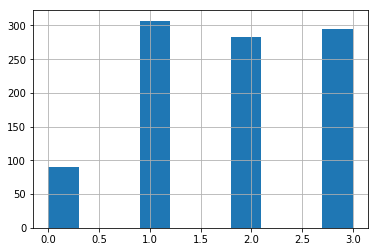

In [4]:
%matplotlib inline
cnts = []
avgs = []
rats = []
mins = []
maxs = []
for n, row in train.replace(to_replace=rating_map).filter(regex=("RATING")).iterrows():
    cnt = 0
    s = -1
    for k,v in row.to_dict().items():
        if v >= 0:
            cnt += 1
            s = v if s < 0 else s+v
    cnts.append(cnt)
    avgs.append(s/cnt if cnt > 0 else -1)
    rats.append(avg2rating(s/cnt if cnt > 0 else -1))
    mins.append(row.min())
    maxs.append(row.max())
   
train['num_experts'] = cnts
train['rating_avg'] = avgs
train['rating'] = rats
train['rating_min'] = mins
train['rating_max'] = maxs
cols = ['FILER_NAME', 'MENTIONED_FINANCIAL_ENTITY', 'ROLE','grp',
        'rating','rating_avg', 'num_experts', 'rating_min','rating_max', 'THREE_SENTENCES', 
        'FILING_DATE', 'DOCUMENT_TYPE', 'FILE', 'FILER_CIK', 'FILING_INTERVAL', 'PP_RSSD_ID']

print('Rating distribution (0-irrelevant, 1-neutral, 2-relevant, 3-highly relevant)')
train['rating'].map(rating_map2).hist()

In [5]:
fil, rol, men = (0,0,0)
mask = []

def k(bo):
    return '(miss)' if not bo else '(y)'

for a,b in train.iterrows():
    t, u , v = False, False, False
    s = b['THREE_SENTENCES'].lower().replace('\n',' ')
    if b['ROLE'].lower() in s:
        rol += 1
        t = True
    if b['MENTIONED_FINANCIAL_ENTITY'].lower() in s:
        men += 1
        u = True
    if b['FILER_NAME'].lower() in s:
        fil += 1
        v = True
    #if not t or not u:
        #print('>',a,b['ROLE'],k(t),'|',b['MENTIONED_FINANCIAL_ENTITY'],k(u),'|',b['FILER_NAME'],k(v),'|',b['FILE'])
        #print(b['THREE_SENTENCES'])
        #print(s)
        #print('----------')
    mask.append(not(not t or not u))
print('Sum:',rol,'|', men,'|', fil)
print('of total:', len(train))
print('after applying mask:',len(train[mask]))

Sum: 971 | 970 | 357
of total: 975
after applying mask: 968


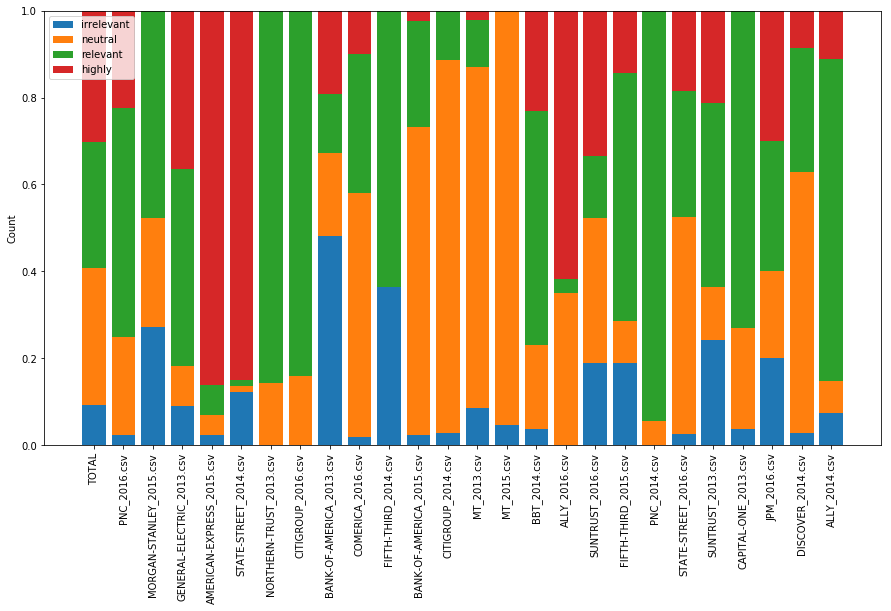

In [428]:
tmpmodel.draw_rating_distribution()

# Classifier

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.svm import SVC
import IPython.display as dp
from pandas import Index

class Lemmatiser(BaseEstimator, TransformerMixin):
    def __init__(self, textcol='THREE_SENTENCES'):
        self.textcol = textcol

    def fit(self, x, y=None):
        return self

    def transform(self, frm):
        if 'clean' in frm.columns:
            return list(frm['clean'])
        
        texts = []
        for doc, row in frm.iterrows():
            tmp = []
            text = row[self.textcol]
            for token in nlp(text):
                if not (token.like_num or \
                        token.is_stop or \
                        token.is_space or \
                        token.is_digit or \
                        token.is_punct or \
                        len(token.orth_)<3):
                    tmp.append(token.lemma_)
            texts.append(' '.join(tmp))
        return texts


class IDFscorer:
    
    def __init__(self, frm, grp=None, train_size=0.6, stratify_docs=True, tritei=None, 
                 twoclassmode=False, enrich=None, lemmatise=True, pipln=[],
                 max_docsplit_iter=15, max_docsplit_diff=0.3):
        
        self.twoclassmode = twoclassmode
        self.ratingmap =  {'irrelevant': 0, 'neutral': 0, 'relevant': 1, 'highly': 1} if twoclassmode else \
                          {'irrelevant': 0, 'neutral': 1, 'relevant': 2, 'highly': 3}
        
        if tritei:
            tri, tei = tritei
        elif not stratify_docs:
            straty = list(frm[mask]['rating']) \
                    if min(Counter(frm[mask]['rating']).values())>1 else None
                
            tri, tei = train_test_split(list(frm[mask].index), 
                                        train_size=train_size, 
                                        stratify=straty)
        else:
            mask = [True]*len(frm) if not grp else (frm['grp']==grp)
            if stratify_docs:
                self.rating_agg = self._get_rating_agg(frm[mask])
                self.files = list(set(frm[mask]['FILE']))
                
                t = train_size*len(frm[mask])
                tri, tei = [],[]
                iter_cnt = 0
                while iter_cnt < max_docsplit_iter:
                    #safeguard against infinite loop
                    iter_cnt += 1
                    
                    rnd_order = np.arange(len(self.files))
                    np.random.shuffle(rnd_order)
                    
                    chosen_files = []
                    for fi in rnd_order:
                        check = chosen_files + [self.files[fi]]
                        tri = list(frm[mask&frm['FILE'].isin(check)].index)
                        tei = list(frm[mask&frm['FILE'].isin(set(self.files)-set(check))].index)
                        
                        # test/train ratio would get too large, so skip!
                        if (len(tri)/len(frm[mask])) > (train_size+0.1):
                            continue
                        
                        chosen_files.append(self.files[fi])
                        
                        if (len(tri)/len(frm[mask])) > train_size:
                            break
                    
                    # sometimes there are not enough docs, so just add one
                    if (len(tri)/len(frm[mask])) < train_size:
                        print('adding emergancy document')
                        chosen_files += list(set(self.files)-set(chosen_files))[0]
                        tri = list(frm[mask&frm['FILE'].isin(chosen_files)].index)
                        tei = list(frm[mask&frm['FILE'].isin(set(self.files)-set(chosen_files))].index)
                    
                    if len(set(frm.loc[tei]['FILE']))<1:
                        print('removing emergancy document')
                        chosen_files.pop()
                        tri = list(frm[mask&frm['FILE'].isin(chosen_files)].index)
                        tei = list(frm[mask&frm['FILE'].isin(set(self.files)-set(chosen_files))].index)
                    
                    a = self._get_rating_agg(frm.loc[tri])
                    b = self._get_rating_agg(frm.loc[tei])
                    
                    #print('diff', np.abs(a.sum(axis=1)/a.sum() - b.sum(axis=1)/b.sum()).sum() )
                    # difference in ratings isn't too bad, keep this split
                    if np.abs(a.sum(axis=1)/a.sum() - b.sum(axis=1)/b.sum()).sum() < (max_docsplit_diff + (max(0, iter_cnt-5)/100)):
                        break
            
        
        self.trainfrm = frm.loc[tri]
        self.testfrm = frm.loc[tei]
        self.grp = grp
        
        if enrich is not None:
            mask = [True]*len(wset) if not grp else (wset['grp']==grp)
            self.trainfrm = pd.concat([self.trainfrm, 
                                       wset[mask].sample(enrich*len(self.trainfrm[self.trainfrm['rating']!='irrelevant']))])\
                              .fillna({'rating': 'irrelevant', 'rating_avg': 0.5})
            
        self.index = {}
        self.texts = []
        
        self.clf = Pipeline(pipln)
        
        if lemmatise:
            self.trainfrm = self.lemmatise(self.trainfrm)
            self.testfrm = self.lemmatise(self.testfrm)
    
    def _get_rating_agg(self, frm):
        # create pivot table
        tmp = frm.pivot_table(values='rating_avg', 
                               columns=['rating'], 
                               index=['FILE'], 
                               aggfunc=lambda x: len(x)).fillna(0)
        cols = ['irrelevant','neutral','relevant','highly']
        
        # fill missing columns
        for c in set(cols)-set(tmp.columns):
            tmp[c] = [0.0]*len(tmp)
        
        return tmp[cols].as_matrix().T
        
    def lemmatise(self, frm): 
        texts = []
        for doc, row in frm.iterrows():
            tmp = []
            text = row['THREE_SENTENCES']
            for token in nlp(text):
                if not (token.like_num or \
                        token.is_stop or \
                        token.is_space or \
                        token.is_digit or \
                        token.is_punct or \
                        len(token.orth_)<3):
                    tmp.append(token.lemma_)
            texts.append(' '.join(tmp))
        frm['clean'] = texts
        return frm
        
        
    def fit(self):
        self.clf.fit(self.trainfrm, self.get_target(frm=self.trainfrm))
    
    
    def predict(self, frm=None):
        # use own testframe if nothing else is requested
        if frm is None:
            frm = self.testfrm
        
        num_targets = 2 if self.twoclassmode else 4
        
        # make prediction (some options don't allow predict_proba, so simulate it!)
        try:
            pred = self.clf.predict_proba(frm)
        except AttributeError as e:
            print('predict_proba failed:', e)
            pred = np.zeros((len(frm), num_targets))
            pred[np.arange(len(frm)), self.clf.predict(frm)] = 1

        # in case a category is missing, add it
        if pred.shape[1] < num_targets:
            tmp = np.zeros((len(pred), num_targets))
            col = 0
            for mi in range(num_targets):
                if mi in set(self.trainfrm['rating'].map(self.ratingmap)):
                    tmp[:,mi:mi+1] = pred[:,col:col+1]
                    col += 1
            pred = tmp
            
        return pred.argmax(axis=1), pred
    
    
    def transform(self, frm=None):
        if frm is None:
            frm = self.testfrm
        
        pred = self.clf.transform(frm, self.get_target(frm=frm))
        return pred.argmax(axis=1), pred
    
    
    def fit_transform(self, frm=None):
        if frm is None:
            frm = self.testfrm
        
        pred = self.clf.fit_transform(frm, self.get_target(frm=frm))
        
        try:
            return pred.argmax(axis=1), pred
        except AttributeError:
            return pred
    
    
    def get_vocabulary(self):
        return self.clf.named_steps['tfidf'].vocabulary_
    
    
    def get_inv_vocabulary(self):
        return {i: w for w,i in self.clf.named_steps['tfidf'].vocabulary_.items()}
    
    
    def get_target(self, frm=None):
        # use own testframe if nothing else is requested
        if frm is None:
            frm = self.testfrm
        return frm['rating'].map(self.ratingmap)
    
    
    def draw_rating_distribution(self, relative=True, include_total=True, figsize=(15,8)):
        files = self.files
        rating_agg = self.rating_agg
        if include_total:
            files = ['TOTAL'] + files
            rating_agg = np.column_stack((self.rating_agg.sum(axis=1), rating_agg))

        if relative:
            rating_agg = rating_agg/rating_agg.sum(axis=0)

        plt.figure(figsize=figsize)

        p0 = plt.bar(np.arange(len(files)), rating_agg[0])
        p1 = plt.bar(np.arange(len(files)), rating_agg[1], bottom=rating_agg[0])
        p2 = plt.bar(np.arange(len(files)), rating_agg[2], bottom=rating_agg[0]+rating_agg[1])
        p3 = plt.bar(np.arange(len(files)), rating_agg[3], bottom=rating_agg[0]+rating_agg[1]+rating_agg[2])

        plt.ylabel('Count')
        plt.xticks(np.arange(len(files)), files, rotation=90)
        plt.legend((p0[0], p1[0], p2[0], p3[0]), ('irrelevant', 'neutral', 'relevant', 'highly'))
        plt.show()
    
    
    def short_setinfo(self):
        print('Items in training set:', len(self.trainfrm),
              '({:.2f}%)'.format(len(self.trainfrm)/(len(self.trainfrm)+len(self.testfrm))*100))
        print('Items in testing set:', len(self.testfrm))
        print(' =', len(self.trainfrm)+len(self.testfrm))
        
        a = len(set(self.trainfrm['FILE']))
        b = len(set(self.testfrm['FILE']))
        print('Number of documents:', a+b, 'toal,',a,'train,',b,'test')
        out = '<table><tr><th></th><th>irrelevant</th><th>neutral</th><th>relevant</th><th>highly</th></tr>'
        out+= '<tr><td>Total (abs)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*self.rating_agg.sum(axis=1))
        out+= '<tr><td>Total (rel)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*self.rating_agg.sum(axis=1)/self.rating_agg.sum())
            
        rats = ['irrelevant', 'neutral', 'relevant', 'highly']
        rattr = self.trainfrm[['rating','rating_avg']].groupby('rating').count()['rating_avg']\
            .reindex(Index(rats)).fillna(0)[rats].as_matrix().reshape((4,))
        ratte = self.testfrm[['rating','rating_avg']].groupby('rating').count()['rating_avg']\
            .reindex(Index(rats)).fillna(0)[rats].as_matrix().reshape((4,))
        out+= '<tr><td>Train (abs)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*rattr)
        out+= '<tr><td>Test (abs)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*ratte)
        out+= '<tr><td>Train (rel)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*(rattr/rattr.sum()))
        out+= '<tr><td>Test (rel)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*(ratte/ratte.sum()))
        out+= '<tr><td>diff</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*((rattr/rattr.sum())-(ratte/ratte.sum())))
        out+= '</table>'
        
        dp.display_html(out, raw=True)
        
        for e in ['RATING_EXPERT_1', 'RATING_EXPERT_2', 'RATING_EXPERT_3','RATING_EXPERT_4', 'RATING_EXPERT_5', 
                  'RATING_EXPERT_6', 'RATING_EXPERT_7', 'RATING_EXPERT_1.1', 'RATING_EXPERT_9','RATING_EXPERT_10']:
            tr = self.trainfrm[self.trainfrm[e].notnull()]
            te = self.testfrm[self.testfrm[e].notnull()]
            if (len(tr)+len(te)) > 0:
                print("{} gave {} ratings, in train: {}, in test: {}.".format(e, 
                                                                              len(tr)+len(te), 
                                                                              len(tr), 
                                                                              len(te)))
            
            
    def establish_baseline(self, include_test=True, include_train=False, num_random=100):
        if include_test and include_train:
            tmp = pd.concat(self.testfrm, self.trainfrm)
        elif include_test:
            tmp = self.testfrm
        else:
            tmp = self.trainfrm

        ndcgtest = []
        for k in range(num_random):
            ndcgtest.append(ndcg2(tmp, [(tmp.index[k],v) for k,v in enumerate(np.random.rand(len(tmp)))]))

        print('NDCG after '+str(num_random)+'x random order:')
        print(' > mean ndcg =', np.mean(ndcgtest), '| std =', np.std(ndcgtest))

        print('NDCG for worst case (inverted best) order:')
        worst = ndcg2(tmp, [(i, abs(self.ratingmap[r['rating']] - (1 if self.twoclassmode else 3))) \
                            for i,r in tmp.iterrows()])
        print(' > ndcg =', worst)
        
        return worst, ndcgtest
    
    
    # TF.IDF Stuff ----------------------------
        
    
    def build_index(self):        
        self.index = {}
        self.texts = []
        for doc, row in self.trainfrm.iterrows():
            tmp = []
            text = row['THREE_SENTENCES']
            for token in nlp(text):
                tmp.append(token.lemma_)
                if not (token.like_num or \
                        token.is_stop or \
                        token.is_space or \
                        token.is_digit or \
                        token.is_punct or \
                        len(token.orth_)<3):
                    
                    if token.lemma_ not in self.index:
                        self.index[token.lemma_] = {
                            'cnt': 0,
                            'docs': {},
                            'ratings': {}
                        }
                    self.index[token.lemma_]['cnt'] += 1
                    self.index[token.lemma_]['docs'][doc] = self.index[token.lemma_]['docs'].get(doc, 0) + 1
                    self.index[token.lemma_]['ratings'][row['rating']] = self.index[token.lemma_]['ratings'].get(row['rating'], 0) + 1
            self.texts.append((doc,tmp))

        self.texts = [(doc,[token for token in text if token in self.index and self.index[token]['cnt'] > 1]) for doc, text in self.texts]
        
        for i,(token, props) in enumerate(self.index.items()):
            self.index[token]['tf'] = np.sum(list(props['docs'].values()))
            self.index[token]['idf'] = len(self.texts)/len(props['docs'])
            self.index[token]['idf_rat'] = len(self.texts)/len(props['ratings'])
            
    
    # @param norm_all if true, divide by all tokens, otherwise only valid ones
    def idf_rank_score(self, norm_all=False, min_tf=0, grp=None):
        scr = []
        scr_rat = []
        mask = [True]*len(self.testfrm) if not grp else (self.testfrm['grp']==grp)
        tmp = self.testfrm[mask].copy(deep=True)
        for doc, row in tmp.iterrows():
            score = 0
            score_r = 0
            l = 0
            for token in nlp(row['THREE_SENTENCES']):
                if token.lemma_ in self.index and self.index[token.lemma_]['tf']>=min_tf:
                    score_r += self.index[token.lemma_]['idf_rat']
                    score += self.index[token.lemma_]['idf']
                    l+= 0 if norm_all else 1
                l+= 1 if norm_all else 0
            l = l if l != 0 else 1
            scr.append((doc, score/l))
            scr_rat.append((doc, score_r/l))

        norminfo = '(divided by num of all tokens)' if norm_all else '(divided by num of valid tokens)'

        print('NDCG based sum of document IDFs in the text'+norminfo+', min TF: '+str(min_tf))
        nda = ndcg2(tmp, scr)
        print('  >', nda)

        print('NDCG based sum of rating IDFs in the text'+norminfo+', min TF: '+str(min_tf))
        ndb = ndcg2(tmp, scr_rat)
        print('  >', ndb)

        return (nda, ndb, scr_rat)
    
    
    def stats_for_sentence(self, doc_id):
        for token in dict(self.texts)[doc_id]:
            itok = self.index[token]
            print(token+'\ttf:', itok['docs'][doc_id], 
                  '\tidf:', '%.2f' % itok['idf'],
                  '\tidf_rat:', '%.2f' % itok['idf_rat'],
                  '\tin docs:', len(itok['docs']),
                  '\tN:', len(self.texts))
    
    
    def print_index(self, sortby='idf', top_n=200):
        for a, b in sorted(list(self.index.items()), reverse=True, key=lambda x: x[1][sortby])[:top_n]:
            print(a,
                  '\t- idf:', b['idf'], 
                  '\t- idf_rat:', b['idf_rat'],
                  '\t- tf:', b['tf'],
                  '\t- in docs:', len(b['docs']))


## Calculate Scores (Four class approach)

* text preprocessing/feature vectors
 * each text is lowercased and lemmatised
 * construct ngrams (length 1-3) for each text and count occurences
 * filter ngrams by min and max document frequency
 * calcuate idf
 * construct vector for text using idf scores of appearing ngrams
* There are 11 classifiers, one for each of the 10 roles and one trained across all roles.
* A classifier targets are the four relevance levels (or two: relevant/irrelevant)
* For each role:
 * split data into training/testing
 * train classifier
 * predict test data using this classifier and the one trained across all roles
 * calculate ranking scores: 
   * sorting score equals class with highest confidence score
   * sorting score equals weighted sum of class confidence scores
 * sort using these scores and calculate four NDCG scores accordingly
 * keep individual scores per item
* sort all test items across roles using previously calculated scores
* calculate all four overall NDCG scores

### Findings/Discussion
* without min/max filter, features of high importance are mostly named entities, suggesting an overfitted model
 * introducing the filter reduces the classification performance, ndcg scores drops from >0.99 to >0.97
* ngram range of 1-3 appears to be good
 * longer ngrams are likely filtered (especially due to few training samples)
 * lower/no ngrams completely disregard context
* classifier class weight
 * dataset is imbalanced, biased towards relevant documents
 * weighting negatively affects accuracy, since more items are classified to be less relevant
 * keeping weights still might be sensible due to the bias; otherwise overfitted
* two classifier types
 * hypothesis and assumptions: training a classifier disregarding the roles provides more training samples under the assumption that wording remains similar with respect to the relevance. on the other hand the role specific wording is neglected
 * the classifier trained over all roles generally performs better, however the effect of few training samples might also an explanation for that
* sorting scores
 * hypothesis: using argmax score for sorting is prone to classification errors, incorporating confidence scores introduces gradient sorting scores
 * hypothesis appears to be proven, although effects are small
 * missclassification one class off likely has no influence on ndcg

In [116]:

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
cv_par = {
    #'ngram_range': (1, 3),
    'min_df': 0.4,
    'max_df': 0.6,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('syntax', Pipeline([
                ('feats', SyntaxFeatures()),
            ])),
            ('bow', Pipeline([
                ('lem', Lemmatiser()),
                ('vect', CountVectorizer(**cv_par)),
                ('tfidf', TfidfTransformer(**tt_par))
            ]))
        ],
        transformer_weights={
            'syntax': 1,
            'bow': 1
        },
    )),
    ('clf', SGDClassifier(**clf_par))
]).fit_transform(tmpmodel.testfrm).toarray()

array([[   4.77746479,  791.2       ,   20.8       , ...,    0.        ,
           0.        ,    0.        ],
       [   4.20266667,  749.6       ,   16.8       , ...,    0.        ,
           0.        ,    0.        ],
       [   4.20266667,  749.6       ,   16.8       , ...,    0.        ,
           0.        ,    0.        ],
       ..., 
       [   4.29538462,  661.6       ,   54.4       , ...,    0.29109298,
           0.24154859,    0.24154859],
       [   4.39663866,  617.6       ,   51.2       , ...,    0.28430657,
           0.25797797,    0.25797797],
       [   4.39663866,  617.6       ,   51.2       , ...,    0.28430657,
           0.25797797,    0.25797797]])

In [140]:
# from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'loss': 'log', #['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
    'penalty': 'l2',
    'shuffle': True,
    'alpha': 1e-4,
    'n_iter': 15,
    'random_state': 42,
    'class_weight': 'balanced'
}

# for SVM
#clf_par = {
#    'C': 1.0,
#    'kernel': 'rbf', # linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
#    #'degree': 5, # polydegree
#    'max_iter': 1000,
#    #'class_weight': 'balanced',
#    'tol': 1e-4,
#}

# temporary storage for macro average score
scores_role = []
scores_full = []
scores_role_proba = []
scores_full_proba = []

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': []
}

def pipln():
    if True:
        return [
            ('lem', Lemmatiser()),
            ('vect', CountVectorizer(**cv_par)),
            ('tfidf', TfidfTransformer(**tt_par)),
            ('clf', SGDClassifier(**clf_par))
        ]
    
    return [
        ('union', FeatureUnion(
            transformer_list=[
                ('syntax', Pipeline([
                    ('feats', SyntaxFeatures()),
                ])),
                ('bow', Pipeline([
                    ('lem', Lemmatiser()),
                    ('vect', CountVectorizer(**cv_par)),
                    ('tfidf', TfidfTransformer(**tt_par))
                ]))
            ],
            transformer_weights={
                'syntax': 1,
                'bow': 1
            },
        )),
        ('clf', SGDClassifier(**clf_par))
    ]

def get_tfidf(clf):
    if True:
        return clf.named_steps['tfidf']
    return clf.named_steps['union'].transformer_list[1][1].named_steps['tfidf']

# prepare model for full set over all roles classifying relevance
svmfullmodel = IDFscorer(frm=train[mask], train_size=0.7,
                         pipln=pipln())
svmfullmodel.short_setinfo()
svmfullmodel.establish_baseline()
svmfullmodel.fit()

print(str(get_tfidf(svmfullmodel.clf)._idf_diag.shape[0])+' features')

# run evaluation for each role
for role in roles.keys():
    print('=== '+role.upper()+' ======')
    
    svmmodel = IDFscorer(frm=train[mask], grp=role,train_size=0.7, max_docsplit_iter=20,
                         pipln=pipln())
    svmmodel.short_setinfo()
    
    bl1, bl2 = svmmodel.establish_baseline(include_test=True, include_train=False)
    res['baseline_rand'].append(bl2)
    res['baseline_worst'].append(bl1)
    
    svmmodel.fit()
    print(str(get_tfidf(svmmodel.clf)._idf_diag.shape[0])+' features')

    # get predictions from model trained on role
    pred_role, pred_proba_role = svmmodel.predict(svmmodel.testfrm)
    
    # get predictions from model trained on all
    pred_full, pred_proba_full = svmfullmodel.predict(svmmodel.testfrm)
    
    score_role = np.sum(pred_proba_role * np.array([1,2,3,4]), axis=1)
    score_full = np.sum(pred_proba_full * np.array([1,2,3,4]), axis=1)

    # calculate accuracy 
    testtarget = svmmodel.get_target()
    res['acc_role'].append(np.mean(pred_role == testtarget))
    print('Accuracy | role :', np.mean(pred_role == testtarget))
    res['acc_full'].append(np.mean(pred_full == testtarget))
    print('Accuracy | full :', np.mean(pred_full == testtarget))

    # print classification report
    print(metrics.classification_report(testtarget, pred_full,
                                        labels=[0,1,2,3],
                                        target_names=list(rating_map2.keys())))

    # print confusion matrix
    print(metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3]))

    # add scores to full list
    score_role_tmp = list(zip(list(svmmodel.testfrm.index), pred_role))
    scores_role += score_role_tmp
    score_full_tmp = list(zip(list(svmmodel.testfrm.index), pred_full))
    scores_full += score_full_tmp
    
    # add scores based on probability to full list
    score_role_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_role))
    scores_role_proba += score_role_proba_tmp
    score_full_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_full))
    scores_full_proba += score_full_proba_tmp
    
    # add NDCG to results
    res['ndcg_role'].append(ndcg2(svmmodel.testfrm, score_role_tmp))
    res['ndcg_role_proba'].append(ndcg2(svmmodel.testfrm, score_role_proba_tmp))
    res['ndcg_full'].append(ndcg2(svmmodel.testfrm, score_full_tmp))
    res['ndcg_full_proba'].append(ndcg2(svmmodel.testfrm, score_full_proba_tmp))
    
    # echo results
    print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_tmp)))
    print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_proba_tmp)))
    print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_tmp)))
    print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_proba_tmp)))
    
    
# echo results of NDCG for entire set
print('TOTAL NDCG | role | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role]], scores_role)))
print('TOTAL NDCG | role | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)))
print('TOTAL NDCG | full | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full]], scores_full)))
print('TOTAL NDCG | full | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)))

Items in training set: 748 (77.27%)
Items in testing set: 220
 = 968
Number of documents: 25 toal, 18 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),72.00,249.00,220.00,207.00
Test (abs),17.00,57.00,60.00,86.00
Train (rel),0.10,0.33,0.29,0.28
Test (rel),0.08,0.26,0.27,0.39
diff,0.02,0.07,0.02,-0.11


RATING_EXPERT_1 gave 406 ratings, in train: 316, in test: 90.
RATING_EXPERT_2 gave 366 ratings, in train: 289, in test: 77.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 10, in test: 25.
RATING_EXPERT_5 gave 80 ratings, in train: 80, in test: 0.
RATING_EXPERT_6 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 132, in test: 90.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 20, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.899981451711 | std = 0.0165241071656
NDCG for worst case (inverted best) order:
 > ndcg = 0.75152438951
333 features
=== INSURER ======
adding emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
Items in training set: 8 (

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),0.00,0.00,7.00,1.00
Test (abs),1.00,1.00,1.00,8.00
Train (rel),0.00,0.00,0.88,0.12
Test (rel),0.09,0.09,0.09,0.73
diff,-0.09,-0.09,0.78,-0.60


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.92414114182 | std = 0.0541313733235
NDCG for worst case (inverted best) order:
 > ndcg = 0.740925426729
746 features
Accuracy | role : 0.0909090909091
Accuracy | full : 0.818181818182
             precision    recall  f1-score   support

 irrelevant       0.50      1.00      0.67         1
    neutral       0.00      0.00      0.00         1
   relevant       0.50      1.00      0.67         1
     highly       1.00      0.88      0.93         8

avg / total       0.82      0.82      0.80        11

[[1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 1 7]]
>

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 133 (71.89%)
Items in testing set: 52
 = 185
Number of documents: 22 toal, 17 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),16.00,32.00,46.00,39.00
Test (abs),10.00,8.00,15.00,19.00
Train (rel),0.12,0.24,0.35,0.29
Test (rel),0.19,0.15,0.29,0.37
diff,-0.07,0.09,0.06,-0.07


RATING_EXPERT_1 gave 81 ratings, in train: 57, in test: 24.
RATING_EXPERT_2 gave 63 ratings, in train: 52, in test: 11.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 10, in test: 15.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_1.1 gave 56 ratings, in train: 22, in test: 34.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 12, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.841155837316 | std = 0.0445811184901
NDCG for worst case (inverted best) order:
 > ndcg = 0.622567925474
522 features
Accuracy | role : 0.346153846154
Accuracy | full : 0.596153846154
             precision    recall  f1-score   support

 irrelevant       0.48      1.00      0.65        10
    neutral       0.00      0.00      0.00         8
   relevant     

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),22.00,35.00,19.00,15.00
Test (abs),10.00,10.00,11.00,7.00
Train (rel),0.24,0.38,0.21,0.16
Test (rel),0.26,0.26,0.29,0.18
diff,-0.02,0.12,-0.08,-0.02


RATING_EXPERT_1 gave 73 ratings, in train: 60, in test: 13.
RATING_EXPERT_2 gave 48 ratings, in train: 34, in test: 14.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 0, in test: 6.
RATING_EXPERT_6 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_7 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_1.1 gave 16 ratings, in train: 10, in test: 6.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.756491693855 | std = 0.0602343532587
NDCG for worst case (inverted best) order:
 > ndcg = 0.535512111102
470 features
Accuracy | role : 0.368421052632
Accuracy | full : 0.684210526316
             precision    recall  f1-score   support

 irrelevant       0.71      1.00      0.83        10
    neutral       0.54      0.70      0.61        10
   relevant       1.00    

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.877966296267 | std = 0.0637470837732
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
1068 features
Accuracy | role : 0.666666666667
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         2
   relevant       0.50      1.00      0.67         2
     highly       0.00      0.00      0.00         2

avg / total       0.50      0.67      0.56         6

[[0 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 2 0]]
> 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



removing emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
Items in training set: 26 (76.47%)
Items in testing set: 8
 = 34
Number of documents: 6 toal, 3 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,1.00,16.00,8.00
Test (abs),0.00,2.00,6.00,0.00
Train (rel),0.04,0.04,0.62,0.31
Test (rel),0.00,0.25,0.75,0.00
diff,0.04,-0.21,-0.13,0.31


RATING_EXPERT_1 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_2 gave 20 ratings, in train: 12, in test: 8.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 14, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.941527184232 | std = 0.0372689953385
NDCG for worst case (inverted best) order:
 > ndcg = 0.847380682018
1224 features
Accuracy | role : 0.25
Accuracy | full : 0.875
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      0.50      0.67         2
   relevant       1.00      1.00      1.00         6
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.88      0.92         8

[[0 0 0 0]
 [1 1 0 0]
 [0 0 6 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.90561
> NDCG Score | role | proba* |

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 310 (74.34%)
Items in testing set: 107
 = 417
Number of documents: 21 toal, 15 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),20.00,124.00,47.00,119.00
Test (abs),0.00,39.00,32.00,36.00
Train (rel),0.06,0.40,0.15,0.38
Test (rel),0.00,0.36,0.30,0.34
diff,0.06,0.04,-0.15,0.05


RATING_EXPERT_1 gave 177 ratings, in train: 177, in test: 0.
RATING_EXPERT_2 gave 145 ratings, in train: 98, in test: 47.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_7 gave 25 ratings, in train: 0, in test: 25.
RATING_EXPERT_1.1 gave 81 ratings, in train: 21, in test: 60.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.884279246949 | std = 0.0241280437098
NDCG for worst case (inverted best) order:
 > ndcg = 0.77850042497
570 features
Accuracy | role : 0.598130841121
Accuracy | full : 0.88785046729
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.97      0.82      0.89        39
   relevant       0.85      0.91      0.88        32
     highly       0.92 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 43 (70.49%)
Items in testing set: 18
 = 61
Number of documents: 17 toal, 8 train, 9 test


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),5.00,8.00,19.00,11.00
Test (abs),1.00,4.00,9.00,4.00
Train (rel),0.12,0.19,0.44,0.26
Test (rel),0.06,0.22,0.50,0.22
diff,0.06,-0.04,-0.06,0.03


RATING_EXPERT_1 gave 26 ratings, in train: 15, in test: 11.
RATING_EXPERT_2 gave 25 ratings, in train: 13, in test: 12.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 18 ratings, in train: 13, in test: 5.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.859675713606 | std = 0.0474051854537
NDCG for worst case (inverted best) order:
 > ndcg = 0.680995855938
726 features
Accuracy | role : 0.444444444444
Accuracy | full : 0.444444444444
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.25      0.25      0.25         4
   relevant       0.56      0.56      0.56         9
     highly       0.67      0.50

,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),1.00,25.00,15.00,3.00
Test (abs),2.00,10.00,3.00,2.00
Train (rel),0.02,0.57,0.34,0.07
Test (rel),0.12,0.59,0.18,0.12
diff,-0.09,-0.02,0.16,-0.05


RATING_EXPERT_1 gave 24 ratings, in train: 20, in test: 4.
RATING_EXPERT_2 gave 30 ratings, in train: 26, in test: 4.
RATING_EXPERT_3 gave 7 ratings, in train: 0, in test: 7.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_1.1 gave 10 ratings, in train: 1, in test: 9.
NDCG after 100x random order:
 > mean ndcg = 0.759991219593 | std = 0.0686011576428
NDCG for worst case (inverted best) order:
 > ndcg = 0.565527904198
602 features
Accuracy | role : 0.588235294118
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         2
    neutral       1.00      1.00      1.00        10
   relevant       1.00      1.00      1.00         3
     highly       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00        

,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,12.00,4.00
Test (abs),0.00,0.00,2.00,3.00
Train (rel),0.00,0.00,0.75,0.25
Test (rel),0.00,0.00,0.40,0.60
diff,0.00,0.00,0.35,-0.35


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 9 ratings, in train: 5, in test: 4.
RATING_EXPERT_5 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_6 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.943940117497 | std = 0.0315863722926
NDCG for worst case (inverted best) order:
 > ndcg = 0.890372377128
703 features
Accuracy | role : 0.4
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         2
     highly       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 0 3]]
> NDCG Score | role | categ  | 0.97947
> NDCG Score | role | proba* | 0.97947
> N

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 toal, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.959755415665 | std = 0.0295160289551
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
1344 features
Accuracy | role : 0.8
Accuracy | full : 0.6
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.50      0.67         4
     highly       1.00      1.00      1.00         1

avg / total       1.00      0.60      0.73         5

[[0 0 0 0]
 [0 0 0 0]
 [0 2 2 0]
 [0 0 0 1]]
> NDCG Score | role |

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [141]:
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.757251,0.455296,0.874892,0.733122,0.979778,0.990792,0.915611,0.960170
std,0.186951,0.210590,0.072666,0.133645,0.031277,0.013633,0.062243,0.045742
min,0.444444,0.090909,0.756492,0.535512,0.907355,0.960399,0.805877,0.877835
25%,0.616667,0.351721,0.845786,0.637175,0.965266,0.983915,0.883699,0.954133
50%,0.751196,0.422222,0.881123,0.740226,0.998995,0.998827,0.917763,0.973738
75%,0.884638,0.595657,0.937181,0.830161,1.000000,1.000000,0.965629,0.992449
max,1.000000,0.800000,0.959755,0.929914,1.000000,1.000000,1.000000,1.000000


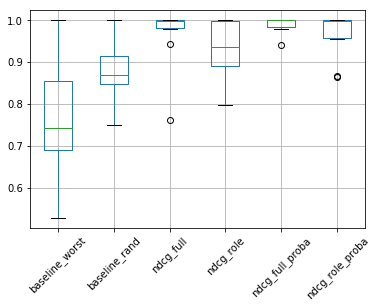

In [24]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

## Neural Net

In [133]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2, activity_l2
from keras.utils import np_utils
from sklearn.multiclass import OneVsRestClassifier
import keras.optimizers as opts
from sklearn.preprocessing import LabelBinarizer


cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.1,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'loss': 'msle',
    'init': 'he_uniform',
    'inner_neurons': 200,
    'dropout': 0.1,
    'activation': 'softsign',
    'batch_size': 10,
    'weights': 'balanced',
    'n_epochs': 15
}

class NNClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, inner_neurons=20, init='he_uniform', dropout=0.1, 
                 regularisation=0.01, activation='softsign', batch_size=10,
                 loss='msle', weights='balanced', n_epochs=5):
        self.inner_neurons = inner_neurons
        self.dropout = dropout
        self.regularisation = regularisation
        self.activation = activation
        self.init = init
        self.batch_size = batch_size
        self.loss = loss
        self.n_epochs = n_epochs
        
        self.balanced = weights == 'balanced'
        
        
    def _prepareNet(self, n_inneurons, n_outneurons):
        try:
            getattr(self, "model")
            getattr(self, "labeler")
        except AttributeError:
            self.model = Sequential()
            self.model.add(Dense(output_dim=n_inneurons, input_dim=n_inneurons, init=self.init))
            self.model.add(Activation("linear"))

            self.model.add(Dense(self.inner_neurons, W_regularizer=l2(self.regularisation), init=self.init))
            self.model.add(Activation(self.activation))
            self.model.add(Dropout(self.dropout))

            self.model.add(Dense(n_outneurons, init=self.init))
            self.model.add(Activation("softmax"))

            #self.model.summary()

            self.model.compile(loss=self.loss,
                          optimizer=opts.Adadelta(),
                          metrics=['accuracy'])

            
    def fit(self, X, y=None):
        X = X.toarray()
        
        y = np.array(y)
        self.ys_ = list(set(y))
        Y = np.zeros((y.shape[0], 4))
        Y[np.arange(y.shape[0]), y] = 1
        
        print('X shape:', X.shape)
        print('Y shape:', Y.shape)
        
        self._prepareNet(X.shape[1], 4)
        
        if self.balanced:
            class_weights = dict((k, 1.0) for k in range(4))
            class_weights.update(dict((key, value) for key, value in zip(self.ys_, 
                                                                    compute_class_weight('balanced', self.ys_, y))))
            print('class weights are balanced:', class_weights)
        else:
            class_weights = None
        
        self.history_ = self.model.fit(X, Y, batch_size=self.batch_size, verbose=0,
                                       nb_epoch=self.n_epochs, class_weight=class_weights)
        return self
    
    
    def predict_proba(self, X, y=None):
        try:
            getattr(self, "history_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
            
        return self.model.predict_proba(X.toarray(), verbose=0)
        

# temporary storage for macro average score
scores_role = []
scores_full = []
scores_role_proba = []
scores_full_proba = []

conf_matrix_role = np.zeros((4,4))
conf_matrix_full = np.zeros((4,4))

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': []
}




#http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py
('union', FeatureUnion(
    transformer_list=[
        
    ])

 
 
 
 
 
 
# prepare model for full set over all roles classifying relevance
svmfullmodel = IDFscorer(frm=train[mask], train_size=0.7,
                         pipln=[
                             ('lem', Lemmatiser()),
                             ('vect', CountVectorizer(**cv_par)),
                             ('tfidf', TfidfTransformer(**tt_par)),
                             ('clf', NNClassifier(**clf_par))
                        ])
svmfullmodel.short_setinfo()
svmfullmodel.establish_baseline()
svmfullmodel.fit()

print(str(svmfullmodel.clf.named_steps['tfidf']._idf_diag.shape[0])+' features')

# run evaluation for each role
for role in roles.keys():
    print('=== '+role.upper()+' ======')
    
    svmmodel = IDFscorer(frm=train[mask], grp=role,train_size=0.7, 
                         pipln=[
                             ('vect', CountVectorizer(**cv_par)),
                             ('tfidf', TfidfTransformer(**tt_par)),
                             ('clf', NNClassifier(**clf_par))
                        ])
    svmmodel.short_setinfo()
    
    bl1, bl2 = svmmodel.establish_baseline(include_test=True, include_train=False)
    res['baseline_rand'].append(bl2)
    res['baseline_worst'].append(bl1)
    
    svmmodel.fit()
    print(str(svmmodel.clf.named_steps['tfidf']._idf_diag.shape[0])+' features')

    # get predictions from model trained on role
    pred_role, pred_proba_role = svmmodel.predict(svmmodel.testfrm)
    
    # get predictions from model trained on all
    pred_full, pred_proba_full = svmfullmodel.predict(svmmodel.testfrm)
    
    score_role = np.sum(pred_proba_role * np.array([1,2,3,4]), axis=1)
    score_full = np.sum(pred_proba_full * np.array([1,2,3,4]), axis=1)

    # calculate accuracy 
    testtarget = svmmodel.get_target()
    res['acc_role'].append(np.mean(pred_role == testtarget))
    print('Accuracy | role :', np.mean(pred_role == testtarget))
    res['acc_full'].append(np.mean(pred_full == testtarget))
    print('Accuracy | full :', np.mean(pred_full == testtarget))

    # print classification report
    print(metrics.classification_report(testtarget, pred_full,
                                        labels=[0,1,2,3],
                                        target_names=list(rating_map2.keys())))

    # print confusion matrix
    conf_matrix_role += np.array(metrics.confusion_matrix(testtarget, pred_role, labels=[0,1,2,3]))
    cm = metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3])
    conf_matrix_full += np.array(cm)
    print(cm)

    # add scores to full list
    score_role_tmp = list(zip(list(svmmodel.testfrm.index), pred_role))
    scores_role += score_role_tmp
    score_full_tmp = list(zip(list(svmmodel.testfrm.index), pred_full))
    scores_full += score_full_tmp
    
    # add scores based on probability to full list
    score_role_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_role))
    scores_role_proba += score_role_proba_tmp
    score_full_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_full))
    scores_full_proba += score_full_proba_tmp
    
    # add NDCG to results
    res['ndcg_role'].append(ndcg2(svmmodel.testfrm, score_role_tmp))
    res['ndcg_role_proba'].append(ndcg2(svmmodel.testfrm, score_role_proba_tmp))
    res['ndcg_full'].append(ndcg2(svmmodel.testfrm, score_full_tmp))
    res['ndcg_full_proba'].append(ndcg2(svmmodel.testfrm, score_full_proba_tmp))
    
    # echo results
    print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_tmp)))
    print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_proba_tmp)))
    print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_tmp)))
    print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_proba_tmp)))
    
    
# echo results of NDCG for entire set
print('TOTAL NDCG | role | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role]], scores_role)))
print('TOTAL NDCG | role | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)))
print('TOTAL NDCG | full | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full]], scores_full)))
print('TOTAL NDCG | full | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)))

Items in training set: 677
Items in testing set: 291
 = 968
Rating distribution in training set: Counter({'neutral': 214, 'highly': 205, 'relevant': 196, 'irrelevant': 62})
Rating distribution in testing set: Counter({'neutral': 92, 'highly': 88, 'relevant': 84, 'irrelevant': 27})
Rating distribution overall: Counter({'neutral': 306, 'highly': 293, 'relevant': 280, 'irrelevant': 89})
RATING_EXPERT_1 gave 406 ratings, in train: 281, in test: 125.
RATING_EXPERT_2 gave 366 ratings, in train: 257, in test: 109.
RATING_EXPERT_3 gave 60 ratings, in train: 45, in test: 15.
RATING_EXPERT_4 gave 35 ratings, in train: 24, in test: 11.
RATING_EXPERT_5 gave 80 ratings, in train: 46, in test: 34.
RATING_EXPERT_6 gave 60 ratings, in train: 36, in test: 24.
RATING_EXPERT_7 gave 74 ratings, in train: 48, in test: 26.
RATING_EXPERT_1.1 gave 222 ratings, in train: 156, in test: 66.
RATING_EXPERT_9 gave 73 ratings, in train: 54, in test: 19.
RATING_EXPERT_10 gave 20 ratings, in train: 15, in test: 5.
NDC

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 129
Items in testing set: 56
 = 185
Rating distribution in training set: Counter({'relevant': 43, 'highly': 40, 'neutral': 28, 'irrelevant': 18})
Rating distribution in testing set: Counter({'relevant': 18, 'highly': 18, 'neutral': 12, 'irrelevant': 8})
Rating distribution overall: Counter({'relevant': 61, 'highly': 58, 'neutral': 40, 'irrelevant': 26})
RATING_EXPERT_1 gave 81 ratings, in train: 54, in test: 27.
RATING_EXPERT_2 gave 63 ratings, in train: 42, in test: 21.
RATING_EXPERT_3 gave 19 ratings, in train: 13, in test: 6.
RATING_EXPERT_4 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_5 gave 25 ratings, in train: 16, in test: 9.
RATING_EXPERT_6 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_7 gave 19 ratings, in train: 14, in test: 5.
RATING_EXPERT_1.1 gave 56 ratings, in train: 40, in test: 16.
RATING_EXPERT_9 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_10 gave 12 ratings, in train: 9, in test: 3.
NDCG after 100x random order:


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 23
Items in testing set: 11
 = 34
Rating distribution in training set: Counter({'relevant': 15, 'highly': 5, 'neutral': 2, 'irrelevant': 1})
Rating distribution in testing set: Counter({'relevant': 7, 'highly': 3, 'neutral': 1})
Rating distribution overall: Counter({'relevant': 22, 'highly': 8, 'neutral': 3, 'irrelevant': 1})
RATING_EXPERT_1 gave 3 ratings, in train: 2, in test: 1.
RATING_EXPERT_2 gave 20 ratings, in train: 15, in test: 5.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 6, in test: 6.
RATING_EXPERT_7 gave 12 ratings, in train: 8, in test: 4.
RATING_EXPERT_1.1 gave 14 ratings, in train: 8, in test: 6.
NDCG after 100x random order:
 > mean ndcg = 0.900118736049 | std = 0.0400668136069
NDCG for worst case (inverted best) order:
 > ndcg = 0.818578583426
X shape: (23, 769)
Y shape: (23, 4)
class weights are balanced: {0: 5.75, 1: 2.875, 2: 0.38333333333333336, 3: 1.1499999999999999}
769 features
Accu

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 291
Items in testing set: 126
 = 417
Rating distribution in training set: Counter({'neutral': 114, 'highly': 108, 'relevant': 55, 'irrelevant': 14})
Rating distribution in testing set: Counter({'neutral': 49, 'highly': 47, 'relevant': 24, 'irrelevant': 6})
Rating distribution overall: Counter({'neutral': 163, 'highly': 155, 'relevant': 79, 'irrelevant': 20})
RATING_EXPERT_1 gave 177 ratings, in train: 121, in test: 56.
RATING_EXPERT_2 gave 145 ratings, in train: 110, in test: 35.
RATING_EXPERT_3 gave 19 ratings, in train: 13, in test: 6.
RATING_EXPERT_5 gave 9 ratings, in train: 3, in test: 6.
RATING_EXPERT_6 gave 25 ratings, in train: 17, in test: 8.
RATING_EXPERT_7 gave 25 ratings, in train: 17, in test: 8.
RATING_EXPERT_1.1 gave 81 ratings, in train: 54, in test: 27.
RATING_EXPERT_9 gave 50 ratings, in train: 36, in test: 14.
RATING_EXPERT_10 gave 3 ratings, in train: 0, in test: 3.
NDCG after 100x random order:
 > mean ndcg = 0.875537902238 | std = 0.02252850

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 42
Items in testing set: 19
 = 61
Rating distribution in training set: Counter({'neutral': 24, 'relevant': 12, 'highly': 4, 'irrelevant': 2})
Rating distribution in testing set: Counter({'neutral': 11, 'relevant': 6, 'highly': 1, 'irrelevant': 1})
Rating distribution overall: Counter({'neutral': 35, 'relevant': 18, 'highly': 5, 'irrelevant': 3})
RATING_EXPERT_1 gave 24 ratings, in train: 19, in test: 5.
RATING_EXPERT_2 gave 30 ratings, in train: 19, in test: 11.
RATING_EXPERT_3 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 5, in test: 1.
RATING_EXPERT_6 gave 3 ratings, in train: 1, in test: 2.
RATING_EXPERT_7 gave 6 ratings, in train: 4, in test: 2.
RATING_EXPERT_1.1 gave 10 ratings, in train: 6, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.821801558032 | std = 0.0509318919407
NDCG for worst case (inverted best) order:
 > ndcg = 0.677867424114
X shape: (42,

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



RATING_EXPERT_5 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.964479894025 | std = 0.0296108639948
NDCG for worst case (inverted best) order:
 > ndcg = 0.931083193486
X shape: (14, 517)
Y shape: (14, 4)
class weights are balanced: {0: 1.0, 1: 4.666666666666667, 2: 0.51851851851851849, 3: 1.1666666666666667}
517 features
Accuracy | role : 0.666666666667
Accuracy | full : 0.5
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.75      0.60      0.67         5
     highly       0.00      0.00      0.00         1

avg / total       0.62      0.50      0.56         6

[[0 0 0 0]
 [0 0 0 0]
 [1 0 3

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [134]:
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.589923,0.622840,0.872608,0.743475,0.946352,0.956398,0.967813,0.971392
std,0.133807,0.169361,0.063819,0.130834,0.045810,0.046044,0.032479,0.038196
min,0.368421,0.368421,0.747196,0.528047,0.855099,0.862805,0.907530,0.887682
25%,0.504464,0.542239,0.837864,0.647909,0.936095,0.929300,0.945519,0.959562
50%,0.571429,0.601504,0.873303,0.730418,0.953706,0.971735,0.975114,0.986113
75%,0.712121,0.659091,0.919620,0.861078,0.982023,0.993736,0.997424,0.996968
max,0.777778,1.000000,0.964480,0.931083,1.000000,1.000000,1.000000,1.000000


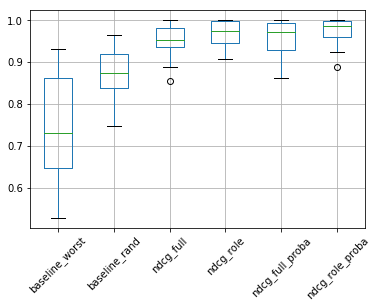

In [135]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

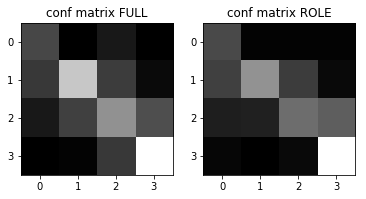

In [136]:

plt.subplot(121)
plt.imshow(conf_matrix_full/conf_matrix_full.max(), cmap='gray')
plt.title('conf matrix FULL')
plt.subplot(122)
plt.imshow(conf_matrix_role/conf_matrix_role.max(), cmap='gray')
plt.title('conf matrix ROLE')
plt.show()

In [138]:
m = svmfullmodel
w = m.clf.named_steps['clf'].model.get_weights()[2].sum(axis=1)
v = {i: w for w,i in m.clf.named_steps['vect'].vocabulary_.items()}
for wi in (w.max()-w).argsort()[:20]:
    print(v[wi],w[wi])

reference exhibit 0.210378
form 10 0.186122
trustee incorporate reference 0.180302
form 0.142248
incorporate reference 0.140631
repurchase 0.139662
january 0.139426
stanley 0.13683
august 0.131257
affiliate 0.128048
market 0.127107
security 0.126249
supplemental 0.114135
case 0.109747
december 0.108756
transaction 0.108363
10 0.106475
settlement 0.103358
amend 0.101792
bank new 0.100879


## Two class approach
Run the same experiment only classifying into relevant and irrelevant. Sorting score using confidence should be sufficient for a good NDCG. More training samples per class may improve overall results.

The NDCG is still calculated using four relevance levels.

In [51]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.03,
    'max_df': 0.9
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'loss': 'log', #['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
    'penalty': 'l2',
    'shuffle': True,
    'alpha': 1e-4,
    'n_iter': 15,
    'random_state': 42,
    'class_weight': 'balanced'
}

# temporary storage for macro average score
scores_role = []
scores_full = []
scores_role_proba = []
scores_full_proba = []

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': []
}



# prepare model for full set over all roles classifying relevance
svmfullmodel = IDFscorer(frm=train[mask], train_size=0.7, twoclassmode=True, 
                         pipln=[
                             ('vect', CountVectorizer(**cv_par)),
                             ('tfidf', TfidfTransformer(**tt_par)),
                             ('clf', SGDClassifier(**clf_par))
                        ])
svmfullmodel.short_setinfo()
svmfullmodel.establish_baseline()
svmfullmodel.fit()

# run evaluation for each role
for role in roles.keys():
    print('\n=== '+role.upper()+' ======')
    
    svmmodel = IDFscorer(frm=train[mask], grp=role,train_size=0.7, twoclassmode=True, 
                         pipln=[
                             ('vect', CountVectorizer(**cv_par)),
                             ('tfidf', TfidfTransformer(**tt_par)),
                             ('clf', SGDClassifier(**clf_par))
                        ])
    svmmodel.short_setinfo()
    
    # establish a baseline score
    bl1, bl2 = svmmodel.establish_baseline(include_test=True, include_train=False)
    res['baseline_rand'].append(bl2)
    res['baseline_worst'].append(bl1)
    
    testtarget = svmmodel.get_target()
    
    try:
        # fit the role based model
        svmmodel.fit()
        
        # get predictions from model trained on role
        pred_role, pred_proba_role = svmmodel.predict(svmmodel.testfrm)
        score_role = np.sum(pred_proba_role * np.array([1,2]), axis=1)
        
        res['acc_role'].append(np.mean(pred_role == testtarget))
        print('Accuracy | role :', np.mean(pred_role == testtarget))
        
        score_role_tmp = list(zip(list(svmmodel.testfrm.index), pred_role))
        scores_role += score_role_tmp
        
        score_role_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_role))
        scores_role_proba += score_role_proba_tmp
        
        res['ndcg_role'].append(ndcg2(svmmodel.testfrm, score_role_tmp))
        res['ndcg_role_proba'].append(ndcg2(svmmodel.testfrm, score_role_proba_tmp))
        
        print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_tmp)))
        print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_proba_tmp)))
    except ValueError as e:
        print("ERROR",e)
        print("excluding this from results")
        
        res['ndcg_role'].append(np.nan)
        res['ndcg_role_proba'].append(np.nan)
        res['acc_role'].append(np.nan)
        # scores_role
        # scores_role_proba
        

    # get predictions from model trained on all
    pred_full, pred_proba_full = svmfullmodel.predict(svmmodel.testfrm)
    score_full = np.sum(pred_proba_full * np.array([1,2]), axis=1)

    # calculate accuracy 
    res['acc_full'].append(np.mean(pred_full == testtarget))
    print('Accuracy | full :', np.mean(pred_full == testtarget))

    # add scores to full list
    score_full_tmp = list(zip(list(svmmodel.testfrm.index), pred_full))
    scores_full += score_full_tmp
    
    # add scores based on probability to full list
    score_full_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_full))
    scores_full_proba += score_full_proba_tmp
    
    # add NDCG to results
    res['ndcg_full'].append(ndcg2(svmmodel.testfrm, score_full_tmp))
    res['ndcg_full_proba'].append(ndcg2(svmmodel.testfrm, score_full_proba_tmp))
    
    # echo results
    print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_tmp)))
    print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_proba_tmp)))
    
    # print classification report
    print(metrics.classification_report(testtarget, pred_full,
                                        labels=[0,1],
                                        target_names=list(svmmodel.ratingmap.keys())))

    # print confusion matrix
    print(metrics.confusion_matrix(testtarget, pred_full, labels=[0,1]))
    

print('\n==== MACROAVERAGE ====')
# echo results of NDCG for entire set
print('TOTAL NDCG | role | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role]], scores_role)))
print('TOTAL NDCG | role | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)))
print('TOTAL NDCG | full | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full]], scores_full)))
print('TOTAL NDCG | full | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)))

Items in training set: 677
Items in testing set: 291
 = 968
Rating distribution in training set: Counter({'relevant': 401, 'irrelevant': 276})
Rating distribution in testing set: Counter({'relevant': 172, 'irrelevant': 119})
Rating distribution overall: Counter({'relevant': 573, 'irrelevant': 395})
RATING_EXPERT_1 gave 406 ratings, in train: 273, in test: 133.
RATING_EXPERT_2 gave 366 ratings, in train: 268, in test: 98.
RATING_EXPERT_3 gave 60 ratings, in train: 38, in test: 22.
RATING_EXPERT_4 gave 35 ratings, in train: 23, in test: 12.
RATING_EXPERT_5 gave 80 ratings, in train: 53, in test: 27.
RATING_EXPERT_6 gave 60 ratings, in train: 43, in test: 17.
RATING_EXPERT_7 gave 74 ratings, in train: 59, in test: 15.
RATING_EXPERT_1.1 gave 222 ratings, in train: 150, in test: 72.
RATING_EXPERT_9 gave 73 ratings, in train: 52, in test: 21.
RATING_EXPERT_10 gave 20 ratings, in train: 17, in test: 3.
NDCG after 100x random order:
 > mean ndcg = 0.888243605959 | std = 0.0156921845508
NDCG fo

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 14
Items in testing set: 6
 = 20
Rating distribution in training set: Counter({'relevant': 13, 'irrelevant': 1})
Rating distribution in testing set: Counter({'relevant': 6})
Rating distribution overall: Counter({'relevant': 19, 'irrelevant': 1})
RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 14 ratings, in train: 9, in test: 5.
RATING_EXPERT_5 gave 4 ratings, in train: 2, in test: 2.
RATING_EXPERT_6 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.931788004216 | std = 0.0347172787239
NDCG for worst case (inverted best) order:
 > ndcg = 0.942474674616
Accuracy | role : 0.833333333333
> NDCG Score | role | categ  | 0.94948
> NDCG Score | role | proba* | 1.00000
Accuracy | full : 1.0
> NDCG Score | full | categ  | 0.94247
> NDC

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [52]:
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,9.000000,10.000000,10.000000,10.000000,10.000000,9.000000,9.000000
mean,0.925516,0.839858,0.870386,0.780387,0.942923,0.959465,0.924677,0.952402
std,0.098054,0.132073,0.056983,0.103468,0.025427,0.042242,0.028386,0.042649
min,0.714286,0.631579,0.754495,0.603305,0.904531,0.881926,0.883767,0.895391
25%,0.924451,0.789474,0.839578,0.716735,0.923889,0.946187,0.911221,0.908740
50%,0.949875,0.833333,0.881213,0.766932,0.943167,0.971572,0.920456,0.964293
75%,1.000000,0.944444,0.914117,0.848359,0.957552,0.991395,0.949479,0.986537
max,1.000000,1.000000,0.931788,0.942475,0.990980,1.000000,0.958222,1.000000


In [49]:
ndcg_np(np.array([0,0,0,0,1,1,1,1]), np.array([1,1,1,1,0,0,0,0]), p=8)

0.48134899354741911

### Classifier internals

In [55]:
pl = svmfullmodel.clf
print('coef shape:', pl.steps[2][1].coef_.shape)
invdict = {i: w for w,i in pl.steps[0][1].vocabulary_.items()}
for role, vec in enumerate(pl.steps[2][1].coef_):
    print()
    print(['irrelevant','neutral', 'relev', 'highly'][role].upper())
    for i, j in zip((-vec).argsort()[:20], vec.argsort()[:20]):
        print("coef: {:.3f}, idf: {:.3f}, word: {:<20} | coef: {:.3f}, idf: {:.3f}, word: {}".format(vec[i], pl.steps[1][1].idf_[i], invdict[i],
                                                                                       vec[j], pl.steps[1][1].idf_[j], invdict[j]))

coef shape: (1, 624)

IRRELEVANT
coef: 4.000, idf: 3.530, word: purchase             | coef: -4.934, idf: 3.830, word: individual
coef: 3.935, idf: 4.341, word: purpose              | coef: -4.459, idf: 4.187, word: thereto
coef: 3.824, idf: 3.360, word: guarantee            | coef: -4.064, idf: 4.384, word: director
coef: 3.719, idf: 3.442, word: loss                 | coef: -3.737, idf: 3.882, word: item
coef: 3.686, idf: 3.830, word: sponsor              | coef: -3.463, idf: 3.549, word: bancorp
coef: 3.573, idf: 3.512, word: payment              | coef: -3.328, idf: 3.648, word: base
coef: 3.547, idf: 2.659, word: capital              | coef: -3.224, idf: 3.549, word: service
coef: 3.496, idf: 3.712, word: investor             | coef: -3.174, idf: 3.830, word: general
coef: 3.491, idf: 4.300, word: seller               | coef: -2.920, idf: 4.187, word: reserve
coef: 3.482, idf: 4.223, word: share                | coef: -2.907, idf: 3.459, word: citigroup
coef: 3.362, idf: 4.300, wo

In [12]:
out = '<ul>'
for a, b in train[mask][10:30].iterrows(): #&(train['rating']=='highly')
    out +='<li>' + b['rating'] + ' | ' + b['THREE_SENTENCES'] \
        .replace(b['MENTIONED_FINANCIAL_ENTITY'],'<b><u>'+b['MENTIONED_FINANCIAL_ENTITY']+'</u></b>') \
        .replace(b['ROLE'],'<b>'+b['ROLE']+'</b>')+'</li>'
    
out += '</ul>'

import IPython.display as dp
dp.display_html(out, raw=True)

highly | As of the same date, we also provided approximately $8.75 billion of credit and liquidity facilities to municipal issuers. TABLE 23: STATE AND MUNICIPAL OBLIGORS (1) (Dollars in millions) Total Municipal Securities Credit and Liquidity Facilities (2) Total % of Total Municipal Exposure December 31, 2015 State of Issuer : Texas $ 1,250 $ 1,962 $ 3,212 17 % California 444 2,220 2,664 14 New York 817 1,259 2,076 11 Massachusetts 927 731 1,658 9 Maryland 454 413 867 5 Total $ 3,892 $ 6,585 $ 10,477 December 31, 2014 State of Issuer : Texas $ 1,326 $ 1,405 $ 2,731 15 % California 458 1,837 2,295 12 New York 920 996 1,916 10 Massachusetts 989 847 1,836 10 Maryland 446 416 862 5 Total $ 4,139 $ 5,501 $ 9,640 (1) Represented 5% or more of our aggregate municipal credit exposure of approximately $18.50 billion and $18.44 billion across our businesses as of December 31, 2015 and December 31, 2014 , respectively. (2) Includes municipal loans which are also presented within Table 26 . highly | As of the same date, we also provided approximately $8.75 billion of credit and liquidity facilities to municipal issuers. TABLE 23: STATE AND MUNICIPAL OBLIGORS (1) (Dollars in millions) Total Municipal Securities Credit and Liquidity Facilities (2) Total % of Total Municipal Exposure December 31, 2015 State of Issuer : Texas $ 1,250 $ 1,962 $ 3,212 17 % California 444 2,220 2,664 14 New York 817 1,259 2,076 11 Massachusetts 927 731 1,658 9 Maryland 454 413 867 5 Total $ 3,892 $ 6,585 $ 10,477 December 31, 2014 State of Issuer : Texas $ 1,326 $ 1,405 $ 2,731 15 % California 458 1,837 2,295 12 New York 920 996 1,916 10 Massachusetts 989 847 1,836 10 Maryland 446 416 862 5 Total $ 4,139 $ 5,501 $ 9,640 (1) Represented 5% or more of our aggregate municipal credit exposure of approximately $18.50 billion and $18.44 billion across our businesses as of December 31, 2015 and December 31, 2014 , respectively. (2) Includes municipal loans which are also presented within Table 26 . highly | As of December 31, 2015 and December 31, 2014 , unearned income deducted from our investment in leveraged lease financing was $102 million and $109 million , respectively, for U.S. leases and $231 million and $261 million , respectively, for non-U.S. leases. The CRE loans are composed of the loans acquired in 2008 pursuant to indemnified repurchase agreements with an affiliate of Lehman as a result of the Lehman Brothers bankruptcy. Additional information about all of our loan-and-lease segments, as well as underlying classes, is provided in Note 4 to the consolidated financial statements included under Item 8 of this Form 10-K. No loans, including CRE loans, were modified in troubled debt restructurings in 2015 or in 2014 . relevant | In addition to credit risk, cross-border outstandings have the risk that, as a result of political or economic conditions in a country, borrowers may be unable to meet their contractual repayment obligations of principal and/or interest when due because of the unavailability of, or restrictions on, foreign exchange needed by borrowers to repay their obligations. We place deposits with non-U.S. counterparties that have strong internal State Street risk ratings. Counterparties are approved and monitored by our Country Risk Committee. relevant | Credit limit approvals across State Street are undertaken by the Credit Risk group, by individuals to whom credit authority has been delegated, or by the Credit Committee. Credit limits are re-evaluated annually, or more frequently as needed, and are revised periodically on prevailing and anticipated market conditions, changes in counterparty or country-specific credit ratings and outlook, changes in State Street 's risk appetite for certain counterparties, sectors or countries, and enhancements to the measurement of credit utilization. Reporting Ongoing active monitoring and management of our credit risk is an integral part of our credit risk management framework. relevant | The watch list is

## LDA

In [114]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

cv_par = {
    #'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
clf_par = {
    'n_topics': 4, 
    'max_iter': 5,
    'learning_method': 'online',
    'learning_offset': 50.,
    'random_state': 0
}

# temporary storage for macro average score
scores_role = []
scores_full = []
scores_role_proba = []
scores_full_proba = []

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': []
}

def print_top_words(model, feature_names, n_top_words, y, yp):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print(sorted(list(zip(Counter(yp[y==topic_idx]).keys(),
                              np.array(list(Counter(yp[y==topic_idx]).values()))/ \
                              np.sum(list(Counter(yp[y==topic_idx]).values()))))))


# prepare model for full set over all roles classifying relevance
svmfullmodel = IDFscorer(frm=train[mask], train_size=0.7, twoclassmode=False, 
                         pipln=[
                            ('vect', CountVectorizer(**cv_par)),
                            ('clf', LatentDirichletAllocation(**clf_par))
                        ])
svmfullmodel.short_setinfo()
svmfullmodel.establish_baseline()
svmfullmodel.fit()

# run evaluation for each role
for role in roles.keys():
    print('\n=== '+role.upper()+' ======')
    
    svmmodel = IDFscorer(frm=train[mask], grp=role,train_size=0.7, twoclassmode=False, 
                         pipln=[
                            ('vect', CountVectorizer(**cv_par)),
                            ('clf', LatentDirichletAllocation(**clf_par))
                        ])
    svmmodel.short_setinfo()
    
    # establish a baseline score
    bl1, bl2 = svmmodel.establish_baseline(include_test=True, include_train=False)
    res['baseline_rand'].append(bl2)
    res['baseline_worst'].append(bl1)
    
    testtarget = svmmodel.get_target()
    

    try:
        # fit the role based model
        svmmodel.fit()
        
        # get predictions from model trained on role
        pred_role, pred_proba_role = svmmodel.transform(svmmodel.testfrm)
        score_role = np.sum(pred_proba_role * np.array([1,2,3,4]), axis=1)
        
        res['acc_role'].append(np.mean(pred_role == testtarget))
        print('Accuracy | role :', np.mean(pred_role == testtarget))
        
        score_role_tmp = list(zip(list(svmmodel.testfrm.index), pred_role))
        scores_role += score_role_tmp
        
        score_role_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_role))
        scores_role_proba += score_role_proba_tmp
        
        res['ndcg_role'].append(ndcg2(svmmodel.testfrm, score_role_tmp))
        res['ndcg_role_proba'].append(ndcg2(svmmodel.testfrm, score_role_proba_tmp))
        
        print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_tmp)))
        print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_proba_tmp)))
    except ValueError as e:
        print("ERROR",e)
        print("excluding this from results")
        
        res['ndcg_role'].append(np.nan)
        res['ndcg_role_proba'].append(np.nan)
        res['acc_role'].append(np.nan)
        # scores_role
        # scores_role_proba
        

    # get predictions from model trained on all
    pred_full, pred_proba_full = svmfullmodel.transform(svmmodel.testfrm)
    score_full = np.sum(pred_proba_full * np.array([1,2,3,4]), axis=1)
    
    # calculate accuracy 
    res['acc_full'].append(np.mean(pred_full == testtarget))
    print('Accuracy | full :', np.mean(pred_full == testtarget))

    # add scores to full list
    score_full_tmp = list(zip(list(svmmodel.testfrm.index), pred_full))
    scores_full += score_full_tmp
    
    # add scores based on probability to full list
    score_full_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_full))
    scores_full_proba += score_full_proba_tmp
    
    # add NDCG to results
    res['ndcg_full'].append(ndcg2(svmmodel.testfrm, score_full_tmp))
    res['ndcg_full_proba'].append(ndcg2(svmmodel.testfrm, score_full_proba_tmp))
    
    # echo results
    print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_tmp)))
    print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_proba_tmp)))
    
    # print classification report
    print(metrics.classification_report(testtarget, pred_full,
                                        labels=[0,1,2,3],
                                        target_names=list(svmmodel.ratingmap.keys())))

    # print confusion matrix
    print(metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3]))
    
    tf_feature_names = svmmodel.clf.named_steps['vect'].get_feature_names()
    print_top_words(svmmodel.clf.named_steps['clf'], tf_feature_names, 15, testtarget, pred_full)
    
print('\n==== MACROAVERAGE ====')
# echo results of NDCG for entire set
print('TOTAL NDCG | role | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role]], scores_role)))
print('TOTAL NDCG | role | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)))
print('TOTAL NDCG | full | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full]], scores_full)))
print('TOTAL NDCG | full | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)))

Items in training set: 677
Items in testing set: 291
 = 968
Rating distribution in training set: Counter({'neutral': 214, 'highly': 205, 'relevant': 196, 'irrelevant': 62})
Rating distribution in testing set: Counter({'neutral': 92, 'highly': 88, 'relevant': 84, 'irrelevant': 27})
Rating distribution overall: Counter({'neutral': 306, 'highly': 293, 'relevant': 280, 'irrelevant': 89})
RATING_EXPERT_1 gave 406 ratings, in train: 283, in test: 123.
RATING_EXPERT_2 gave 366 ratings, in train: 260, in test: 106.
RATING_EXPERT_3 gave 60 ratings, in train: 44, in test: 16.
RATING_EXPERT_4 gave 35 ratings, in train: 22, in test: 13.
RATING_EXPERT_5 gave 80 ratings, in train: 55, in test: 25.
RATING_EXPERT_6 gave 60 ratings, in train: 36, in test: 24.
RATING_EXPERT_7 gave 74 ratings, in train: 56, in test: 18.
RATING_EXPERT_1.1 gave 222 ratings, in train: 159, in test: 63.
RATING_EXPERT_9 gave 73 ratings, in train: 53, in test: 20.
RATING_EXPERT_10 gave 20 ratings, in train: 14, in test: 6.
NDC

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 129
Items in testing set: 56
 = 185
Rating distribution in training set: Counter({'relevant': 43, 'highly': 40, 'neutral': 28, 'irrelevant': 18})
Rating distribution in testing set: Counter({'highly': 18, 'relevant': 18, 'neutral': 12, 'irrelevant': 8})
Rating distribution overall: Counter({'relevant': 61, 'highly': 58, 'neutral': 40, 'irrelevant': 26})
RATING_EXPERT_1 gave 81 ratings, in train: 54, in test: 27.
RATING_EXPERT_2 gave 63 ratings, in train: 48, in test: 15.
RATING_EXPERT_3 gave 19 ratings, in train: 13, in test: 6.
RATING_EXPERT_4 gave 8 ratings, in train: 3, in test: 5.
RATING_EXPERT_5 gave 25 ratings, in train: 14, in test: 11.
RATING_EXPERT_6 gave 14 ratings, in train: 9, in test: 5.
RATING_EXPERT_7 gave 19 ratings, in train: 18, in test: 1.
RATING_EXPERT_1.1 gave 56 ratings, in train: 39, in test: 17.
RATING_EXPERT_9 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_10 gave 12 ratings, in train: 11, in test: 1.
NDCG after 100x random order:

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 23
Items in testing set: 11
 = 34
Rating distribution in training set: Counter({'relevant': 14, 'highly': 6, 'neutral': 2, 'irrelevant': 1})
Rating distribution in testing set: Counter({'relevant': 8, 'highly': 2, 'neutral': 1})
Rating distribution overall: Counter({'relevant': 22, 'highly': 8, 'neutral': 3, 'irrelevant': 1})
RATING_EXPERT_1 gave 3 ratings, in train: 1, in test: 2.
RATING_EXPERT_2 gave 20 ratings, in train: 13, in test: 7.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 8, in test: 4.
RATING_EXPERT_7 gave 12 ratings, in train: 9, in test: 3.
RATING_EXPERT_1.1 gave 14 ratings, in train: 10, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.909520077452 | std = 0.0354052186371
NDCG for worst case (inverted best) order:
 > ndcg = 0.834284151592
Accuracy | role : 0.454545454545
> NDCG Score | role | categ  | 0.90428
> NDCG Score | role | proba* | 0.89349
Accuracy | full : 0.636363636364
> N

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Topic #0:
net income loss expense cash revenue asset loan total intercompany sale lease debt financing investment
[]
Topic #1:
basis company guarantee senior llc note statement adjustment consolidated fully nonguarantors intercompany holding condensed include
[(1, 1.0)]
Topic #2:
net income loan loss total cash expense intercompany revenue asset nonbank receivables debt sale investment
[(2, 0.75), (3, 0.25)]
Topic #3:
file form company guarantee reference incorporate exhibit capital bank corporation warrant specimen january trustee agreement
[(2, 1.0)]

=== TRUSTEE ======
Items in training set: 291
Items in testing set: 126
 = 417
Rating distribution in training set: Counter({'neutral': 114, 'highly': 108, 'relevant': 55, 'irrelevant': 14})
Rating distribution in testing set: Counter({'neutral': 49, 'highly': 47, 'relevant': 24, 'irrelevant': 6})
Rating distribution overall: Counter({'neutral': 163, 'highly': 155, 'relevant': 79, 'irrelevant': 20})
RATING_EXPERT_1 gave 177 ratings, in 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 42
Items in testing set: 19
 = 61
Rating distribution in training set: Counter({'neutral': 24, 'relevant': 12, 'highly': 4, 'irrelevant': 2})
Rating distribution in testing set: Counter({'neutral': 11, 'relevant': 6, 'highly': 1, 'irrelevant': 1})
Rating distribution overall: Counter({'neutral': 35, 'relevant': 18, 'highly': 5, 'irrelevant': 3})
RATING_EXPERT_1 gave 24 ratings, in train: 17, in test: 7.
RATING_EXPERT_2 gave 30 ratings, in train: 23, in test: 7.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_5 gave 6 ratings, in train: 4, in test: 2.
RATING_EXPERT_6 gave 3 ratings, in train: 2, in test: 1.
RATING_EXPERT_7 gave 6 ratings, in train: 4, in test: 2.
RATING_EXPERT_1.1 gave 10 ratings, in train: 6, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.826600658098 | std = 0.0577965583626
NDCG for worst case (inverted best) order:
 > ndcg = 0.677867424114
Accuracy | rol

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 14
Items in testing set: 6
 = 20
Rating distribution in training set: Counter({'relevant': 10, 'highly': 3, 'neutral': 1})
Rating distribution in testing set: Counter({'relevant': 4, 'highly': 2})
Rating distribution overall: Counter({'relevant': 14, 'highly': 5, 'neutral': 1})
RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 9, in test: 5.
RATING_EXPERT_5 gave 4 ratings, in train: 2, in test: 2.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.932726001515 | std = 0.0285476099592
NDCG for worst case (inverted best) order:
 > ndcg = 0.880521329339
Accuracy | role : 0.5
> NDCG Score | role | categ  | 0.88753
> NDCG Score | role | proba* | 0.88052
Accuracy | full : 0.5
> NDCG Score | full | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [84]:
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.087825,0.283391,0.870886,0.736003,0.855298,0.828324,0.855496,0.866348
std,0.091437,0.173177,0.065207,0.128672,0.089038,0.105414,0.078149,0.083833
min,0.000000,0.105263,0.742514,0.528047,0.688681,0.687760,0.748046,0.775913
25%,0.013158,0.172932,0.830855,0.647909,0.801157,0.751340,0.791339,0.791895
50%,0.064777,0.270292,0.879604,0.729511,0.895335,0.821584,0.860361,0.857195
75%,0.141775,0.320513,0.914287,0.844973,0.926200,0.921486,0.884818,0.927756
max,0.285714,0.714286,0.962173,0.931083,0.939754,0.986302,1.000000,1.000000


In [112]:
a, b = svmfullmodel.transform(svmfullmodel.trainfrm)
y = svmfullmodel.trainfrm['rating'].map(svmfullmodel.ratingmap)
for i in range(4):
    print(i, sorted(list(zip(Counter(a[y==i]).keys(),np.array(list(Counter(a[y==i]).values()))/np.sum(list(Counter(a[y==i]).values()))))))


0 [(0, 0.30645161290322581), (1, 0.016129032258064516), (2, 0.032258064516129031), (3, 0.64516129032258063)]
1 [(0, 0.35046728971962615), (1, 0.34112149532710279), (2, 0.051401869158878503), (3, 0.2570093457943925)]
2 [(0, 0.18877551020408162), (1, 0.1326530612244898), (2, 0.26530612244897961), (3, 0.41326530612244899)]
3 [(1, 0.014634146341463415), (2, 0.80487804878048785), (3, 0.18048780487804877)]


## TF.IDF (Baseline)
* Calculate sorting scores using normalised IDF score (Sum of IDFs of each valid token in text divided by number of tokens in text).
 * alternatively normalise dividing by number of tokens (as opposed to only number of valid tokens)
* IDF calculated across texts with same relevance and role ("document" equivalent to all texts with same relevance and role)
* another index is constructed disregarding the role for comparison ("document" equivalent to all texts with same relevance)
* another index is only constructed disregarding both, relevance and role (normal IDF over documents)

In [20]:
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'scr_doc_all': [],
    'scr_doc_valid': [],
    'scr_doc_min_tf': [],
    'scr_rat_all': [],
    'scr_rat_valid': [],
    'scr_rat_min_tf': [],
    'scr_doc_min_tf_full': [],
    'scr_rat_min_tf_full': []
}
all_scores = []

fullidfsort = IDFscorer(train[mask], train_size=0.8)
fullidfsort.short_setinfo()

for role in roles.keys():
    print('===> '+role.upper()+" <==========")
    idfsort = IDFscorer(train[mask], role, train_size=0.8)
    idfsort.short_setinfo()
    print("=> BASELINE _____")
    bl1, bl2 = idfsort.establish_baseline(include_test=True, include_train=False)
    res['baseline_rand'] += bl2
    res['baseline_worst'].append(bl1)
    print("=> SCORING normalise by all _____")
    d,r, _ = idfsort.idf_rank_score(norm_all=True)
    res['scr_doc_all'].append(d)
    res['scr_rat_all'].append(r)
    print("=> SCORING normalise by valid ______")
    d,r, _ = idfsort.idf_rank_score(norm_all=False)
    res['scr_doc_valid'].append(d)
    res['scr_rat_valid'].append(r)
    d,r, s = idfsort.idf_rank_score(norm_all=False, min_tf=2)
    res['scr_doc_min_tf'].append(d)
    res['scr_rat_min_tf'].append(r)
    all_scores += s
    
    print("=> SCORING from full set ______")
    d,r,_ = fullidfsort.idf_rank_score(grp=role, min_tf=2)
    res['scr_doc_min_tf_full'].append(d)
    res['scr_rat_min_tf_full'].append(r)
    
print('\nTRAINED per role')
tmp = ndcg2(frame=train.loc[[k for k,v in all_scores]], scoring=all_scores)
print('Overall NDCG: '+str(tmp))
tmp = ndcg2(frame=train.loc[[k for k,v in all_scores]], 
    scoring=[(k,v) for k,v in abs(train.loc[[k for k,v in all_scores]]['rating'].map(rating_map2)-3).iteritems()])
print('worst case overall ndcg: '+str(tmp))

print('\nTRAINED TOGETHER')
d,r,s= fullidfsort.idf_rank_score(min_tf=2)
tmp = ndcg2(frame=fullidfsort.testfrm, scoring=s)
print('Overall NDCG: '+str(tmp))
tmp = ndcg2(frame=fullidfsort.testfrm, 
    scoring=[(k,v) for k,v in abs(fullidfsort.testfrm['rating'].map(rating_map2)-3).iteritems()])
print('worst case overall ndcg: '+str(tmp))

Items in training set: 774
Items in testing set: 194
 = 968
Rating distribution in training set: Counter({'neutral': 245, 'highly': 234, 'relevant': 224, 'irrelevant': 71})
Rating distribution in testing set: Counter({'neutral': 61, 'highly': 59, 'relevant': 56, 'irrelevant': 18})
Rating distribution overall: Counter({'neutral': 306, 'highly': 293, 'relevant': 280, 'irrelevant': 89})
RATING_EXPERT_1 gave 406 ratings, in train: 318, in test: 88.
RATING_EXPERT_2 gave 366 ratings, in train: 297, in test: 69.
RATING_EXPERT_3 gave 60 ratings, in train: 47, in test: 13.
RATING_EXPERT_4 gave 35 ratings, in train: 27, in test: 8.
RATING_EXPERT_5 gave 80 ratings, in train: 62, in test: 18.
RATING_EXPERT_6 gave 60 ratings, in train: 50, in test: 10.
RATING_EXPERT_7 gave 74 ratings, in train: 61, in test: 13.
RATING_EXPERT_1.1 gave 222 ratings, in train: 177, in test: 45.
RATING_EXPERT_9 gave 73 ratings, in train: 59, in test: 14.
RATING_EXPERT_10 gave 20 ratings, in train: 16, in test: 4.
===> I

In [21]:
res['baseline_rand'] = np.mean(res['baseline_rand'])
pd.DataFrame(res).describe()

,baseline_rand,baseline_worst,scr_doc_all,scr_doc_min_tf,scr_doc_min_tf_full,scr_doc_valid,scr_rat_all,scr_rat_min_tf,scr_rat_min_tf_full,scr_rat_valid
count,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,8.749960e-01,0.745947,0.871012,0.871012,0.909651,0.871012,0.871012,0.871012,0.909651,0.871012
std,1.170278e-16,0.147528,0.104597,0.104597,0.067187,0.104597,0.104597,0.104597,0.067187,0.104597
min,8.749960e-01,0.498838,0.648238,0.648238,0.796830,0.648238,0.648238,0.648238,0.796830,0.648238
25%,8.749960e-01,0.658240,0.829844,0.829844,0.871123,0.829844,0.829844,0.829844,0.871123,0.829844
50%,8.749960e-01,0.717779,0.910867,0.910867,0.903175,0.910867,0.910867,0.910867,0.903175,0.910867
75%,8.749960e-01,0.865748,0.938578,0.938578,0.953219,0.938578,0.938578,0.938578,0.953219,0.938578
max,8.749960e-01,0.943775,0.985277,0.985277,1.000000,0.985277,0.985277,0.985277,1.000000,0.985277


# Inter Annotator Agreement

Calculate normalised confusion matrix for each pair of experts. Not additional output is given for those pairs without any overlapping contributions.

This uses Cohen's Kappa ("change of random agreement")
* https://staff.fnwi.uva.nl/r.fernandezrovira/teaching/MoLProject2011/annotation-reliability.pdf

In [7]:
def kappa(ca, cb):
    translationmap = {'irrelevant': 0, 'neutral': 1, 'relevant': 2, 'highly relevant': 3}
    
    # build confusion matrix
    confmat = np.ndarray((4,4))
    for a, b in zip(ca, cb):
        confmat[translationmap[a.lower()]][translationmap[b.lower()]] += 1
    
    s = confmat.sum()
    
    # normalise
    confmat = confmat/s
    
    # expected random agreement (sum over products of row/column sums)
    Ae = (confmat.sum(axis=0)*confmat.sum(axis=1)).sum()
    
    # annotator agreement
    A0 = confmat.diagonal().sum()
    
    # calculate kappa
    k = (A0-Ae)/(1-Ae)
    
    return (confmat, k, s)


experts = ['RATING_EXPERT_1', 'RATING_EXPERT_2', 'RATING_EXPERT_3','RATING_EXPERT_4', 'RATING_EXPERT_5', 'RATING_EXPERT_6','RATING_EXPERT_7', 'RATING_EXPERT_1.1', 'RATING_EXPERT_9','RATING_EXPERT_10']
tmp = []
kmap = np.zeros((10,10))
smap = np.zeros((10,10))
for i,e in enumerate(experts):
    for j in range(i+1, len(experts)):
        cm, k, s = kappa(train[pd.notnull(train[experts[i]])&pd.notnull(train[experts[j]])][experts[i]],
                         train[pd.notnull(train[experts[i]])&pd.notnull(train[experts[j]])][experts[j]])
        kmap[i][j] = k
        smap[i][j] = s
        print(experts[i],'&',experts[j],'| overlap='+str(s),'| k='+str(k))
        if not np.isnan(k):
            print(cm)
            print()
        
        tmp.append({'ca':experts[i],'cb':experts[j], 'k':k,'s':s})
agreement = pd.DataFrame(tmp)

RATING_EXPERT_1 & RATING_EXPERT_2 | overlap=128.0 | k=0.258426966292
[[ 0.0234375  0.0078125  0.         0.       ]
 [ 0.         0.1953125  0.1796875  0.       ]
 [ 0.         0.078125   0.1171875  0.0625   ]
 [ 0.         0.0234375  0.1640625  0.1484375]]

RATING_EXPERT_1 & RATING_EXPERT_3 | overlap=24.0 | k=0.942307692308
[[ 0.29166667  0.          0.          0.        ]
 [ 0.          0.29166667  0.          0.        ]
 [ 0.          0.          0.08333333  0.        ]
 [ 0.          0.          0.04166667  0.29166667]]

RATING_EXPERT_1 & RATING_EXPERT_4 | overlap=35.0 | k=0.533333333333
[[ 0.02857143  0.          0.          0.        ]
 [ 0.02857143  0.08571429  0.05714286  0.        ]
 [ 0.          0.05714286  0.51428571  0.02857143]
 [ 0.          0.          0.08571429  0.11428571]]

RATING_EXPERT_1 & RATING_EXPERT_5 | overlap=11.0 | k=0.0
[[ 0.          0.90909091  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.     

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


In [12]:
agreement

,ca,cb,k,s
0,RATING_EXPERT_1,RATING_EXPERT_2,0.258427,128.0
1,RATING_EXPERT_1,RATING_EXPERT_3,0.942308,24.0
2,RATING_EXPERT_1,RATING_EXPERT_4,0.533333,35.0
3,RATING_EXPERT_1,RATING_EXPERT_5,0.000000,11.0
4,RATING_EXPERT_1,RATING_EXPERT_6,NaN,0.0
5,RATING_EXPERT_1,RATING_EXPERT_7,0.400000,3.0
6,RATING_EXPERT_1,RATING_EXPERT_1.1,-0.055888,23.0
7,RATING_EXPERT_1,RATING_EXPERT_9,NaN,0.0
8,RATING_EXPERT_1,RATING_EXPERT_10,0.060877,8.0
9,RATING_EXPERT_2,RATING_EXPERT_3,NaN,0.0


In [11]:
(agreement['k']*agreement['s']/agreement['s'].sum()).sum()

0.44809992744108257

In [23]:
agreement.describe()

,k,s
count,27.000000,45.000000
mean,0.341679,10.622222
std,0.346240,22.366055
min,-0.055888,0.000000
25%,0.064183,0.000000
50%,0.089241,1.000000
75%,0.537217,12.000000
max,1.000000,128.000000


For a better overview the kappa scores visually for all pairs of annotators. Empty cells indicate, that there are no overlapping ratings. 

The plot on the left shows kappa values, that on the right the number of overlapping ratings.

In [ ]:
vals = np.nan_to_num(smap.T+kmap)
for i in range(smap.shape[0]):
    for j in range(smap.shape[1]):
        print(#"{}({},{}) [{:.2f}]".format(
            "{} {} {:.2f}".format(
            #"%" if not vals[i][j] else "",
            i, j,
            vals[i][j]
            ))

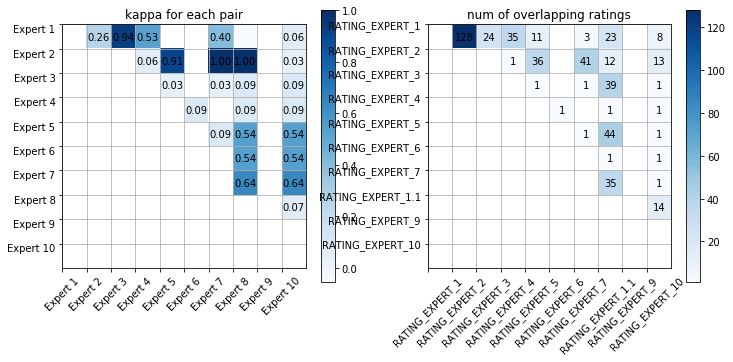

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib2tikz import save as tikz_save

plt.clf()

labs = ["Expert "+str(i+1) for i,_ in enumerate(experts)]

fig = plt.figure(figsize=(12, 5))

sub = fig.add_subplot(1,2,1)
sub.set_title('kappa for each pair')
kmap[kmap==0] = np.nan
im = sub.imshow(kmap, cmap=cm.Blues)
kmap[kmap==np.nan] = 0

ind_array = np.arange(0,10,1)
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c='%.2f'%kmap[y_val][x_val] if kmap[y_val][x_val]>0 else ''
    sub.text(x_val, y_val, c, va='center', ha='center')

sub.set_yticks(np.arange(-0.5, 9.5))
sub.set_yticklabels(labs, va="top")
sub.set_xticks(np.arange(-0.5, 9.5))
sub.set_xticklabels(labs, rotation=45)
sub.grid()

fig.colorbar(im, ax=sub)

sub = fig.add_subplot(1,2,2)
sub.set_title('num of overlapping ratings')
smap[smap==0] = np.nan
im = sub.imshow(smap, cmap=cm.Blues)
smap[smap==np.nan] = 0

ind_array = np.arange(0,10,1)
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c='%.0f'%smap[y_val][x_val] if smap[y_val][x_val]>0 else ''
    sub.text(x_val, y_val, c, va='center', ha='center')

sub.set_yticks(np.arange(-0.5, 9.5))
sub.set_yticklabels(experts)
sub.set_xticks(np.arange(-0.5, 9.5))
sub.set_xticklabels(experts, rotation=45)
sub.grid()
    
fig.colorbar(im, ax=sub)
plt.tight_layout()

plt.show()

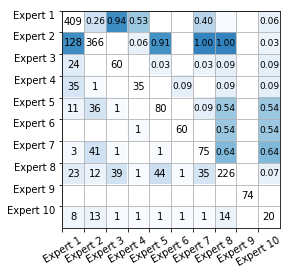

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib2tikz import save as tikz_save

plt.clf()

labs = ["Expert "+str(i+1) for i,_ in enumerate(experts)]

fig = plt.figure()

sub = fig.add_subplot(111)
#sub.set_title('kappa for each pair')
kmap[kmap==0] = np.nan
im = sub.imshow(kmap, cmap=cm.Blues, vmax=1.5)
kmap[kmap==np.nan] = 0

ind_array = np.arange(0,10,1)
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c='%.2f'%kmap[y_val][x_val] if kmap[y_val][x_val]>0 else ''
    sub.text(x_val, y_val, c, va='center', ha='center', fontsize=9)

sub.set_yticks(np.arange(-0.5, 9.5))
sub.set_yticklabels(labs, va="top")
sub.set_xticks(np.arange(-0.5, 9.5))
sub.set_xticklabels(labs, rotation=30)
sub.grid()

smap = smap.T
smap[smap==0] = np.nan
im = sub.imshow(smap, cmap=cm.Blues, vmax=200)
#sub.clim(-4,4)
smap[smap==np.nan] = 0

ind_array = np.arange(0,10,1)
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c='%.0f'%smap[y_val][x_val] if smap[y_val][x_val]>0 else ''
    sub.text(x_val, y_val, c, va='center', ha='center', fontsize=10)
smap = smap.T

for i, expert in enumerate(experts):
    sub.text(i, i, train[pd.notnull(train[expert])].shape[0], va='center', ha='center', fontsize=10)

#plt.tight_layout()
plt.savefig(os.path.join('/home/tim/Uni/HPI/workspace/FEII/paper', 'iaa.pdf'))

plt.show()

This small overview shows, that most tuples are only rated by one expert. ~40% of them are rated by two experts, only few from more than that.

In [26]:
train[['num_experts', 'rating_avg',]].groupby('num_experts').count()

,rating_avg
num_experts,
0,3
1,567
2,377
3,28


# Feature Selection
## Information Gain

In [82]:
d = 6
print(5/d)
print(5//d)

0.8333333333333334
0


In [94]:
def log(x, base):
    return np.log(x)/np.log(base)

def entropy(x):
    s = 0
    for v in set(x):
        s += (len(x[x==v])/len(x))*np.log2(len(x[x==v])/len(x))
    return -s

def information_gain(X, y, a, bins=None):
    X_a = X[:,a]
    
    if bins is not None:
        X_a = (X_a - X_a.min())//((X_a.max()-X_a.min())/bins).clip(max=bins-1)
    
    s = 0
    for v in set(X_a):
        s += (len(X_a[X_a==v])/len(X)) * entropy(y[X_a==v])
        
    return entropy(y) - s

In [60]:
from sklearn.feature_selection  import chi2

def calIG(kv):
    k,v = kv
    return (v, information_gain(X.toarray(), y, k))

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}

np.set_printoptions(suppress=True)

tmpmodel = IDFscorer(frm=train[mask],
                     train_size=0.9, 
                     pipln=[
                            ('lem', Lemmatiser()),
                            ('vect', CountVectorizer(**cv_par)),
                            ('tfidf', TfidfTransformer(**tt_par))
                     ])
tmpmodel.short_setinfo()

X = tmpmodel.fit_transform(frm=tmpmodel.trainfrm)
y = tmpmodel.get_target(frm=tmpmodel.trainfrm)
dic = {i: w for w,i in tmpmodel.clf.named_steps['vect'].vocabulary_.items()}

from multiprocessing import Pool

print('X shape', X.shape)

p = Pool(7)
gains = p.map(calIG, dic.items())
p.close()

out = '<table><tr><th>Information Gain</th><th>chi2 p-Value</th></tr>'
out+= '<tr><td>' + pp(sorted(gains, key=lambda tup: tup[1], reverse=True)) + \
     '</td><td>' + pp(sorted(zip(dic.values(), chi2(X,y)[1]), key=lambda tup: tup[1], reverse=True)) + \
     '</td></tr>'
out+= '</table>'

    
HTML(out)

Items in training set: 889 (91.84%)
Items in testing set: 79
 = 968
Number of documents: 25 toal, 22 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),79.00,280.00,251.00,279.00
Test (abs),10.00,26.00,29.00,14.00
Train (rel),0.09,0.31,0.28,0.31
Test (rel),0.13,0.33,0.37,0.18
diff,-0.04,-0.01,-0.08,0.14


RATING_EXPERT_1 gave 406 ratings, in train: 360, in test: 46.
RATING_EXPERT_2 gave 366 ratings, in train: 331, in test: 35.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 25, in test: 10.
RATING_EXPERT_5 gave 80 ratings, in train: 80, in test: 0.
RATING_EXPERT_6 gave 60 ratings, in train: 27, in test: 33.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 222, in test: 0.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 19, in test: 1.
X shape (889, 312)


Information Gain,chi2 p-Value


In [100]:
class SyntaxFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, asfrm=False, n_workers=6):
        self.asfrm = asfrm
        self.n_workers = n_workers
        
    def fit(self, X, y=None):
        return self

    def transform(self, frm):
        p = Pool(self.n_workers)
        Xd = pd.DataFrame(p.map(self._features, frm.iterrows()), index=frm.index)
        p.close()
        
        if (self.asfrm):
            return Xd
        
        return Xd.as_matrix()
    
    def _features(self, row):
        _, row = row
        raw = row['THREE_SENTENCES']
        clean = row['clean']
        counts_r = Counter(raw.split())
        counts_c = Counter(clean.split())
        ret = {
            'num_chars': len(raw),
            'num_words': len(raw.split()),
            'num_upper_chars': sum(1 for c in raw if c.isupper()),
            'num_upper_words': sum(1 for w in raw.split() if w[0].isupper()),
            'ratio_upper_chars': sum(1 for c in raw if c.isupper())/len(raw),
            'ratio_upper_words': sum(1 for w in raw.split() if w[0].isupper())/len(raw.split()),
            'mean_word_len': np.mean([len(w) for w in raw.split()]),
            'num_word_repetitions_raw': len({k:v for k,v in counts_r.items() if v>1}),
            'num_word_repetitions_clean': len({k:v for k,v in counts_c.items() if v>1}),
            'num_word_repetitions_raw_rel': len({k:v for k,v in counts_r.items() if v>1})/len(raw.split()),
            'num_word_repetitions_clean_rel': len({k:v for k,v in counts_c.items() if v>1})/len(clean.split()),
        }
        return ret
    
p = Pipeline([('ff', SyntaxFeatures(asfrm=True))])

frm = tmpmodel.trainfrm

Xd = p.transform(frm) 
X = Xd.as_matrix()
y = tmpmodel.get_target(frm)

print('X shape', X.shape)
print('y shape', y.shape)

def calcIG(kv):
    a, k = kv
    return (k, information_gain(X, y, a, bins=5))

p = Pool(7)
gains = p.map(calcIG, enumerate(Xd.columns))
p.close()

print(list(enumerate(Xd.columns)))

out = '<table><tr><th>Information Gain</th><th>chi2 p-Value</th></tr>'
out+= '<tr><td>' + pp(sorted(gains, key=lambda tup: tup[1], reverse=True)) + \
     '</td><td>' + pp(sorted(zip(Xd.columns, chi2(X,y)[1]), key=lambda tup: tup[1], reverse=True)) + \
     '</td></tr>'
out+= '</table>'

    
HTML(out)

#print('Information Gain')
#sorted(gains, key=lambda tup: tup[1], reverse=True)

X shape (889, 11)
y shape (889,)
[(0, 'mean_word_len'), (1, 'num_chars'), (2, 'num_upper_chars'), (3, 'num_upper_words'), (4, 'num_word_repetitions_clean'), (5, 'num_word_repetitions_clean_rel'), (6, 'num_word_repetitions_raw'), (7, 'num_word_repetitions_raw_rel'), (8, 'num_words'), (9, 'ratio_upper_chars'), (10, 'ratio_upper_words')]


Information Gain,chi2 p-Value
"[('num_chars', 1.2036787128125594), ('num_words', 0.65417817180244842), ('num_upper_chars', 0.34543015314608327), ('num_word_repetitions_raw', 0.27570322721709473), ('num_upper_words', 0.25701949164468285), ('ratio_upper_words', 0.19805219978118904), ('num_word_repetitions_clean', 0.18192097075528668), ('num_word_repetitions_raw_rel', 0.10206854151818345), ('num_word_repetitions_clean_rel', 0.10118282661967148), ('mean_word_len', 0.038707870311922354), ('ratio_upper_chars', 0.037718718273172858)]","[('mean_word_len', 0.9450396336652287), ('num_word_repetitions_raw_rel', 0.94042430360139695), ('num_word_repetitions_clean_rel', 0.88278717609740442), ('ratio_upper_chars', 0.7693523638310259), ('num_upper_words', 0.23238234002460587), ('ratio_upper_words', 0.043417765817968072), ('num_upper_chars', 2.2107700463014292e-18), ('num_word_repetitions_clean', 9.8649207503151001e-42), ('num_word_repetitions_raw', 2.9827283430831713e-68), ('num_chars', 0.0), ('num_words', 0.0)]"


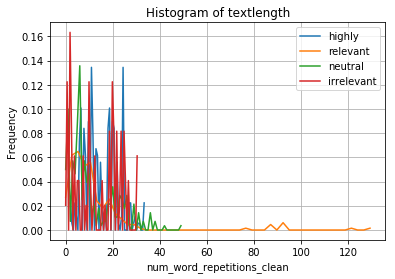

In [101]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

bins = 20
# tmp = pd.DataFrame({'rating':train['rating'], 'len':train['THREE_SENTENCES'].str.len()})

col = 4

for i, a in enumerate(['highly', 'relevant',  'neutral','irrelevant']):
    x = X[:,col][y==abs(3-i)]
    n, bins = np.histogram(x, 50, normed=1)

    f = interp1d(bins[:-1], n, kind='cubic')
    l = plt.plot(bins[:-1], f(bins[:-1]), label=a)

plt.xlabel(Xd.columns[col])
plt.ylabel('Frequency')
plt.title('Histogram of textlength')
#plt.xlim(0,500)
plt.legend()
plt.grid(True)

## RFE

In [235]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.utils import compute_class_weight

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'loss': 'log', #['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
    'penalty': 'l2',
    'shuffle': True,
    'alpha': 1e-4,
    'n_iter': 15,
    'random_state': 42,
    'class_weight': 'balanced'
}

tmpmodel = IDFscorer(frm=train[mask],grp='trustee', train_size=0.7, cv_par=cv_par, tt_par=tt_par, clf_par=clf_par)
tmpmodel.short_setinfo()

prep = Pipeline([('vect', CountVectorizer(**cv_par)),
             ('tfidf', TfidfTransformer(**tt_par))
            ])

X_raw = list(tmpmodel.trainfrm['clean']) + list(tmpmodel.testfrm['clean'])
X = prep.fit_transform(X_raw)
y = np.array(list(tmpmodel.trainfrm['rating'].map(tmpmodel.ratingmap)) + \
             list(tmpmodel.testfrm['rating'].map(tmpmodel.ratingmap)))

_, M = prep.named_steps['vect']._count_vocab(X_raw, True)
_, Mtr = prep.named_steps['vect']._count_vocab(list(tmpmodel.trainfrm['clean']), True)
_, Mte = prep.named_steps['vect']._count_vocab(list(tmpmodel.testfrm['clean']), True)

print(X.shape)
print(y.shape)

clf = SGDClassifier(**clf_par)

selector = RFE(clf, 100, step=1)
selector = selector.fit(X, y)

dic = {i: w for w,i in prep.named_steps['vect'].vocabulary_.items()}

tfs = np.sum(M, axis=0).A1
dfs = np.bincount(M.indices, minlength=M.shape[1])
class_weights = dict((key, value) for key, value in enumerate(compute_class_weight('balanced', list(set(tmpmodel.trainfrm['rating'].map(tmpmodel.ratingmap))), np.array(tmpmodel.trainfrm['rating'].map(tmpmodel.ratingmap)))))

print('num features selected:', selector.n_features_)
print('document frequencies are class_weight adjusted!')
print(class_weights)
for a in np.argsort(abs(np.array(selector.ranking_)-max(selector.ranking_))):
    print('{}sup: {:>3} irr|neu|rel|hig {:>3}|{:>3}|{:>3}|{:>3} idf: {:.3f} {}'.format(
                                    '*' if not selector.support_[a] else ' ', # in selection y/n
                                    selector.ranking_[a], # support
                                    int(class_weights.get(0,0)*np.bincount(M[y==0].indices, minlength=M[y==0].shape[1])[a]),
                                    int(class_weights.get(1,0)*np.bincount(M[y==1].indices, minlength=M[y==1].shape[1])[a]) or 0,
                                    int(class_weights.get(2,0)*np.bincount(M[y==2].indices, minlength=M[y==2].shape[1])[a]) or 0,
                                    int(class_weights.get(3,0)*np.bincount(M[y==3].indices, minlength=M[y==3].shape[1])[a]) or 0,
                                    prep.named_steps['tfidf'].idf_[a], # IDF
                                    dic[a])) # word

Items in training set: 845
Items in testing set: 126
 = 971
Rating distribution in training set: Counter({'irrelevant': 568, 'neutral': 114, 'highly': 108, 'relevant': 55})
Rating distribution in testing set: Counter({'neutral': 49, 'highly': 47, 'relevant': 24, 'irrelevant': 6})
Rating distribution overall: Counter({'irrelevant': 574, 'neutral': 163, 'highly': 155, 'relevant': 79})
RATING_EXPERT_1 gave 177 ratings, in train: 123, in test: 54.
RATING_EXPERT_2 gave 145 ratings, in train: 97, in test: 48.
RATING_EXPERT_3 gave 19 ratings, in train: 14, in test: 5.
RATING_EXPERT_5 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_6 gave 25 ratings, in train: 19, in test: 6.
RATING_EXPERT_7 gave 25 ratings, in train: 17, in test: 8.
RATING_EXPERT_1.1 gave 81 ratings, in train: 61, in test: 20.
RATING_EXPERT_9 gave 50 ratings, in train: 35, in test: 15.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
(971, 412)
(971,)
num features selected: 100
document frequencies are class_w

In [185]:
df0 = np.sum(np.bincount(M[y==0].indices, minlength=M[y==0].shape[1]))
df1 = np.sum(np.bincount(M[y==1].indices, minlength=M[y==1].shape[1]))
df2 = np.sum(np.bincount(M[y==2].indices, minlength=M[y==2].shape[1]))
df3 = np.sum(np.bincount(M[y==3].indices, minlength=M[y==3].shape[1]))


-2.7027459722928278

## t-SNE

Items in training set: 396
Items in testing set: 21
 = 417
Rating distribution in training set: Counter({'neutral': 155, 'highly': 147, 'relevant': 75, 'irrelevant': 19})
Rating distribution in testing set: Counter({'neutral': 8, 'highly': 8, 'relevant': 4, 'irrelevant': 1})
Rating distribution overall: Counter({'neutral': 163, 'highly': 155, 'relevant': 79, 'irrelevant': 20})
RATING_EXPERT_1 gave 177 ratings, in train: 165, in test: 12.
RATING_EXPERT_2 gave 145 ratings, in train: 138, in test: 7.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 23, in test: 2.
RATING_EXPERT_7 gave 25 ratings, in train: 23, in test: 2.
RATING_EXPERT_1.1 gave 81 ratings, in train: 78, in test: 3.
RATING_EXPERT_9 gave 50 ratings, in train: 48, in test: 2.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.


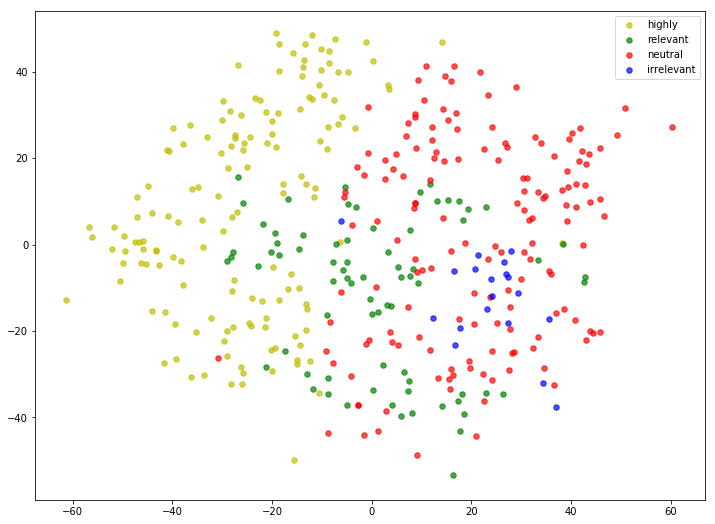

In [27]:
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.utils import compute_class_weight
import matplotlib.pyplot as plt

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'n_components': 2, 
    'random_state': 0,
    #'init': 'pca',
    'method': 'exact'
}

np.set_printoptions(suppress=True)

tmpmodel = IDFscorer(frm=train[mask],
                     grp='trustee', 
                     train_size=0.95, 
                     pipln=[('vect', CountVectorizer(**cv_par)),
                            ('tfidf', TfidfTransformer(**tt_par)),
                            ('clf', TSNE(**clf_par))
                     ])
tmpmodel.short_setinfo()
#tmpmodel.fit_transform()
y = np.array(tmpmodel.get_target(frm=tmpmodel.trainfrm))

plt.figure(figsize=(12,9))
_, X_red = tmpmodel.fit_transform(frm=tmpmodel.trainfrm)

plt.scatter(X_red[y==3][:,0], X_red[y==3][:,1], marker='o', color='y', alpha=0.7, s = 30, label='highly')
plt.scatter(X_red[y==2][:,0], X_red[y==2][:,1], marker='o', color='g', alpha=0.7, s = 30, label='relevant')
plt.scatter(X_red[y==1][:,0], X_red[y==1][:,1], marker='o', color='r', alpha=0.7, s = 30, label='neutral')
plt.scatter(X_red[y==0][:,0], X_red[y==0][:,1], marker='o', color='b', alpha=0.7, s = 30, label='irrelevant')

plt.legend(loc='upper right')

plt.show()

## LSA

Items in training set: 396
Items in testing set: 21
 = 417
Rating distribution in training set: Counter({'neutral': 155, 'highly': 147, 'relevant': 75, 'irrelevant': 19})
Rating distribution in testing set: Counter({'neutral': 8, 'highly': 8, 'relevant': 4, 'irrelevant': 1})
Rating distribution overall: Counter({'neutral': 163, 'highly': 155, 'relevant': 79, 'irrelevant': 20})
RATING_EXPERT_1 gave 177 ratings, in train: 170, in test: 7.
RATING_EXPERT_2 gave 145 ratings, in train: 141, in test: 4.
RATING_EXPERT_3 gave 19 ratings, in train: 18, in test: 1.
RATING_EXPERT_5 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_6 gave 25 ratings, in train: 23, in test: 2.
RATING_EXPERT_7 gave 25 ratings, in train: 24, in test: 1.
RATING_EXPERT_1.1 gave 81 ratings, in train: 76, in test: 5.
RATING_EXPERT_9 gave 50 ratings, in train: 47, in test: 3.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
[ 0.03438845  0.10274323]
0.137131680989
components shape: (2, 579)


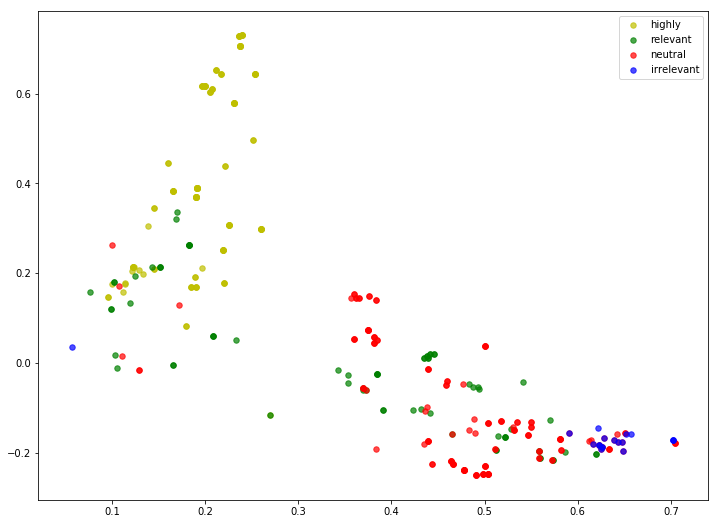

In [29]:
%matplotlib inline

from sklearn.utils import compute_class_weight
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'n_components':2, 
    'n_iter':7, 
    'random_state': 42
}

np.set_printoptions(suppress=True)

tmpmodel = IDFscorer(frm=train[mask],
                     grp='trustee', 
                     train_size=0.95, 
                     pipln=[('vect', CountVectorizer(**cv_par)),
                            ('tfidf', TfidfTransformer(**tt_par)),
                            ('clf', TruncatedSVD(**clf_par))
                     ])
tmpmodel.short_setinfo()

y = np.array(tmpmodel.get_target(frm=tmpmodel.trainfrm))

plt.figure(figsize=(12,9))
_, X_red = tmpmodel.fit_transform(frm=tmpmodel.trainfrm)

print(tmpmodel.clf.named_steps['clf'].explained_variance_ratio_) 
print(tmpmodel.clf.named_steps['clf'].explained_variance_ratio_.sum()) 
dic = {i: w for w,i in tmpmodel.clf.named_steps['vect'].vocabulary_.items()}
class_weights = dict((key, value) for key, value in enumerate(compute_class_weight('balanced', list(set(tmpmodel.trainfrm['rating'].map(tmpmodel.ratingmap))), np.array(tmpmodel.trainfrm['rating'].map(tmpmodel.ratingmap)))))
print('components shape:', tmpmodel.clf.named_steps['clf'].components_.shape)

plt.scatter(X_red[y==3][:,0], X_red[y==3][:,1], marker='o', color='y', alpha=0.7, s = 30, label='highly')
plt.scatter(X_red[y==2][:,0], X_red[y==2][:,1], marker='o', color='g', alpha=0.7, s = 30, label='relevant')
plt.scatter(X_red[y==1][:,0], X_red[y==1][:,1], marker='o', color='r', alpha=0.7, s = 30, label='neutral')
plt.scatter(X_red[y==0][:,0], X_red[y==0][:,1], marker='o', color='b', alpha=0.7, s = 30, label='irrelevant')

plt.legend(loc='upper right')

plt.show()

In [ ]:
# from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_features = 1000
n_topics =4
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
#dataset = fetch_20newsgroups(shuffle=True, random_state=1,
#                             remove=('headers', 'footers', 'quotes'))
#data_samples = dataset.data[:n_samples]
#data_samples = list(train[mask&((train['grp']=='issuer')|(train['grp']=='affiliate')|(train['grp']=='trustee'))]['THREE_SENTENCES'])
data_samples = list(train[mask]['THREE_SENTENCES'])
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (len(train[mask]), n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (len(train[mask]), n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

In [47]:
tf_vectorizer.transform([row['THREE_SENTENCES']])

<1x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [57]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

target_names = ['irrelevant','neutral','relevant','highly']
print(classification_report(y, yp, target_names=target_names))

confusion_matrix(y, yp)

             precision    recall  f1-score   support

 irrelevant       0.14      0.19      0.16        89
    neutral       0.71      0.70      0.70       306
   relevant       0.34      0.42      0.37       280
     highly       0.36      0.24      0.29       293

avg / total       0.44      0.43      0.43       968



array([[ 17,  26,   9,  37],
       [ 21, 213,  29,  43],
       [ 59,  59, 117,  45],
       [ 27,   2, 193,  71]])

## WordEmbedding doc2vec

In [181]:
from gensim.models import Doc2Vec
from bs4 import BeautifulSoup
from gensim.models.doc2vec import LabeledSentence
from multiprocessing import Pool

reportsdir = '/home/tim/Uni/HPI/workspace/FEII/full_reports/'
cleantext = ""
for cnt, file in enumerate(os.listdir(reportsdir)):
    if file.endswith('.html'):
        print('reading: '+file)
        with open(reportsdir+file,"r",encoding='utf-8', errors='ignore') as f:
            cleantext += BeautifulSoup(f.read(), "html5lib").text
        
    if cnt > 4:
        break

print('extracting sentences...')
sents = [str(s).lower() for s in nlp(cleantext).sents]

reading: ALLY_2016.html
reading: ALLY_2014.html
reading: CAPITAL-ONE_2013.html
extracting sentences...


In [182]:
labsents = [LabeledSentence(words=s.split(), tags=['SENT_'+str(i)]) for i,s in enumerate(sents)]

In [244]:
model = Doc2Vec(size=52, window=10, min_count=5, 
                workers=6, alpha=0.025, min_alpha=0.025,
                batch_words=100, dm=0) 
model.build_vocab(labsents)
for epoch in range(10):
    print(epoch)
    model.train(labsents)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

0
1
2
3
4
5
6
7
8
9


In [184]:
for epoch in range(10,20):
    print(epoch)
    model.train(labsents)

10
11
12
13
14
15
16
17
18
19


In [246]:
print('words:', len(cleantext.split()))
print('sentences:',len(sents))

words: 362039
sentences: 12435


In [245]:
model.most_similar('ally',topn=20)

[('holding', 0.5321180820465088),
 ('contentsally', 0.507906973361969),
 ('allys', 0.47115761041641235),
 ('institutions,', 0.47101694345474243),
 ('company', 0.44708943367004395),
 ("contentsmanagement's", 0.4458065927028656),
 ('company,', 0.44410091638565063),
 ('agreement,', 0.4360629916191101),
 ('chair', 0.43117034435272217),
 ('discontinue', 0.4120597243309021),
 ('ally,', 0.40910500288009644),
 ('assets', 0.40478575229644775),
 ('nonmember', 0.4009893834590912),
 ('us.', 0.39565375447273254),
 ('us', 0.3944399058818817),
 ('funding.', 0.3942679166793823),
 ('fhc', 0.3941538631916046),
 ('remain', 0.3896048665046692),
 ('secrecy', 0.38228362798690796),
 ('chase', 0.3791976571083069)]

In [238]:
from pprint import pprint 

se = 'As of December 31, 2013 , the capital of each of these banking subsidiaries exceeded the minimum legal capital requirements set by those regulatory authorities.'
tmp = model.infer_vector(se.lower().split())
print('Model:', model)
print('inferred vector:', tmp)
print()
print(se.lower())
pprint(model.most_similar([tmp]))

for sn, fl in model.docvecs.most_similar([tmp]):
    print(">> {:.4f} >> \n{}".format(fl, ' '.join(sents[int(sn[5:])].split())))


Model: Doc2Vec(dm/m,d2,n5,w10,mc5,s0.001,t6)
inferred vector: [ 0.22850589  0.09040408]

as of december 31, 2013 , the capital of each of these banking subsidiaries exceeded the minimum legal capital requirements set by those regulatory authorities.
[('originally', 0.9999997019767761),
 ('excluded', 0.9999954700469971),
 ('properties', 0.9999945163726807),
 ('rights', 0.999993622303009),
 ('charged', 0.9999935626983643),
 ('addition', 0.9999926686286926),
 ('eurodollar', 0.999988317489624),
 ('approximates', 0.9999845027923584),
 ('court', 0.9999825954437256),
 ('lessee', 0.9999793767929077)]
>> 1.0000 >> 
the average balance of commercial banking loans held for investment, excluding the carrying value of acquired loans, was $35.1 billion, $30.8 billion and $29.1 billion in 2012, 2011 and 2010, respectively.
>> 1.0000 >> 
the loss sharing amounts due from kohls are recorded as a reduction in our provision for credit losses in our consolidated statements of income.
>> 1.0000 >> 
we are 

In [266]:
import random
while True:
    word = random.choice(model.wv.index2word)
    if model.wv.vocab[word].count > 10:
        break

print("most similar words for '%s' (%d occurences)" % (word, model.wv.vocab[word].count))

print(str(model.most_similar(word, topn=20)).replace('), ','),\n'))

most similar words for 'submit' (31 occurences)
[('company-run', 0.719616174697876),
('frb.', 0.6296055316925049),
('submitted', 0.5708451867103577),
('declare', 0.5196664929389954),
('expects', 0.5091995596885681),
('stress', 0.49763205647468567),
('purpose,', 0.4951915740966797),
('adequacy', 0.48403048515319824),
('test', 0.48100733757019043),
('compare', 0.47804659605026245),
('(131)', 0.46424561738967896),
('tests', 0.46380940079689026),
('discretionary', 0.4479648172855377),
('contribute', 0.4461285471916199),
('23%', 0.4386689066886902),
('parent', 0.4366167485713959),
('plan,', 0.43326708674430847),
('presentation.', 0.4303516149520874),
('261', 0.42970341444015503),
('staff.', 0.4267594814300537)]


In [ ]:
sections = model.accuracy('questions-words.txt')
correct, incorrect = len(sections[-1]['correct']), len(sections[-1]['incorrect'])
print('%s: %0.2f%% correct (%d of %d)' % (model, float(correct*100)/(correct+incorrect), correct, correct+incorrect))

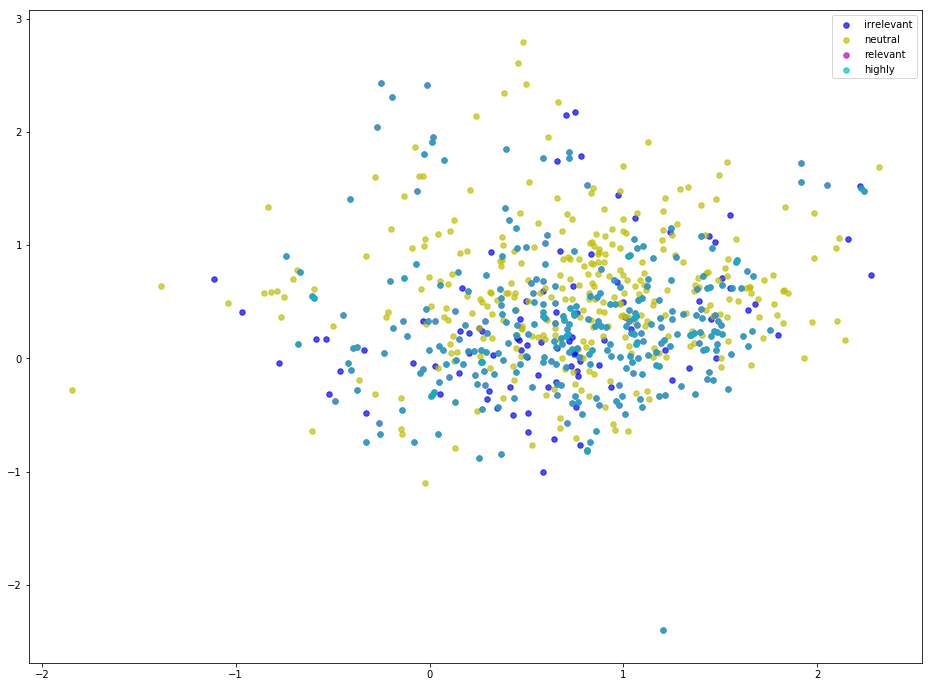

In [209]:
%matplotlib inline

import matplotlib.pyplot as plt

X = list(train['THREE_SENTENCES'])
y = np.array(train['rating'].map(rating_map2))

X_red = np.array([model.infer_vector(se.lower().split()) for se in X])

plt.figure(figsize=(16,12))
#X_red = svd.transform(X)

plt.scatter(X_red[y==0][:,0],
            X_red[y==0][:,1],
            # the marker as
            marker='o',
            # the color
            color='b',
            # the alpha
            alpha=0.7,
            # with size
            s = 30,
            # labelled this
            label='irrelevant')

plt.scatter(X_red[y==1][:,0],
            X_red[y==1][:,1],
            # the marker as
            marker='o',
            # the color
            color='y',
            # the alpha
            alpha=0.7,
            # with size
            s = 30,
            # labelled this
            label='neutral')

plt.scatter(X_red[y==2][:,0],
            X_red[y==2][:,1],
            # the marker as
            marker='o',
            # the color
            color='m',
            # the alpha
            alpha=0.7,
            # with size
            s = 30,
            # labelled this
            label='relevant')

plt.scatter(X_red[y==2][:,0],
            X_red[y==2][:,1],
            # the marker as
            marker='o',
            # the color
            color='c',
            # the alpha
            alpha=0.7,
            # with size
            s = 30,
            # labelled this
            label='highly')

# and a legend
plt.legend(loc='upper right')

plt.show()

# Example Listing

In [126]:
skip = 500
limit = 20

experts = ['EXPERT_1', 'EXPERT_2', 'EXPERT_3','EXPERT_4', 'EXPERT_5', 'EXPERT_6','EXPERT_7', 'EXPERT_1.1', 'EXPERT_9','EXPERT_10']

for n, row in train.sort_values('rating_avg', ascending=True)[skip:skip+limit].iterrows():
    print('>>>>> '+str(n)+' rating: '+row['rating']+' | ' + row['FILER_NAME']+' - '+row['ROLE'] + ' - '+row['MENTIONED_FINANCIAL_ENTITY'])
    print(row['THREE_SENTENCES'])
    print('---')
    for exp in experts:
        if not pd.isnull(row['RATING_'+exp]):
            print('  - ' + exp+': '+str(row['RATING_'+exp])+' > '+ str(row['COMMENT_'+exp]))
    
    print('---')
    print()
    #print(row)

>>>>> 817 rating: relevant | CAPITAL ONE FINANCIAL CORP - trustee - The Bank of New York Mellon Trust Company, N.A.
4.5.4
Guarantee Agreement, dated as of August 1, 2006, between Capital One Financial Corporation and The Bank of New York Mellon Trust Company, N.A., as guarantee trustee
(incorporated by reference to Exhibit 4.4 of the Corporation?s Current Report on Form 8-K, filed on August 4, 2006).4.5.5
---
  - EXPERT_2: Relevant > -1.1.-1
---

>>>>> 822 rating: relevant | CAPITAL ONE FINANCIAL CORP - Trustee - BNY Mellon Trust of Delaware
4.7.2
Amended and Restated Declaration of Trust of Capital One Capital V, dated as of August 5, 2009, between Capital One Financial Corporation as Sponsor, The Bank of New York
Mellon Trust Company, N.A., as institutional trustee, BNY Mellon Trust of Delaware, as Delaware Trustee and the Administrative Trustees named therein (incorporated by reference to Exhibit 4.3 of the Corporation?s Current Report on Form 8-K,
filed on August 6, 2009).4.7.3
---

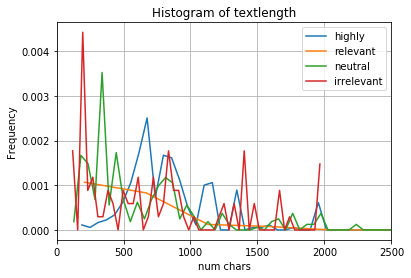

In [125]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

bins = 20
# tmp = pd.DataFrame({'rating':train['rating'], 'len':train['THREE_SENTENCES'].str.len()})

for a in ['highly', 'relevant',  'neutral','irrelevant']:
    x = np.array(train[train['rating']==a]['THREE_SENTENCES'].str.len())
    n, bins = np.histogram(x, 50, normed=1)

    f = interp1d(bins[:-1], n, kind='cubic')
    l = plt.plot(bins[:-1], f(bins[:-1]), label=a)

plt.xlabel('num chars')
plt.ylabel('Frequency')
plt.title('Histogram of textlength')
#plt.axis([0,2000, 0, 140])#0.004])
plt.xlim(0,2500)
plt.legend()
plt.grid(True)

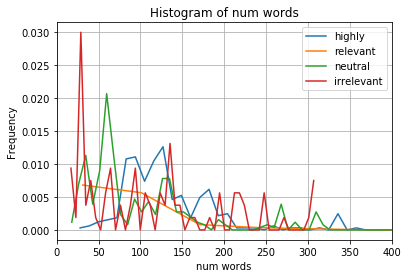

In [41]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

bins = 20
# tmp = pd.DataFrame({'rating':train['rating'], 'len':train['THREE_SENTENCES'].str.len()})

for a in ['highly', 'relevant',  'neutral','irrelevant']:
    x = np.array([len(s.split()) for _,s in train[train['rating']==a]['THREE_SENTENCES'].iteritems()])
    n, bins = np.histogram(x, 50, normed=1)

    f = interp1d(bins[:-1], n, kind='cubic')
    l = plt.plot(bins[:-1], f(bins[:-1]), label=a)

plt.xlabel('num words')
plt.ylabel('Frequency')
plt.title('Histogram of num words')
#plt.axis([0,2000, 0, 140])#0.004])
plt.xlim(0,400)
plt.legend()
plt.grid(True)